# Проект: Линейные модели в машинном обучении

К нам обратился фермер с молочного хозяйства, который хочет купить бурёнок, чтобы расширить поголовье стада коров. Поскольку он может тщательно выбирать бурёнок, он попросил составить модели, которые будут подбирать ему бурёнок с максимально возможным удоем молока, а также модель которая будет подбирать коров с вкусным молоком. 

В нашем распоряжений данные о коровах с фирмы "ЭкоФерма" и их "характеристики".

Наш план работы будет состоять из нескольких последовательных этапов:

- Изучение общей информации по датасету
- Выполним предобработку данных ради достижения более качественных результатов исследования (замена пропусков, удаление выбросов, добавление новых столбцов)
- Проведем исследовательский анализ показателей
- Проведем корреляционный анализ, для построения модели МО
- Обучим МО для нужных параметров
- Сделаем итоговый вывод

## Шаг 1: Загрузка данных

### Импортируем нужные библиотеки

In [807]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
import scipy.stats as st
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder 
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix
from sklearn.metrics import r2_score
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score

### Загрузим данные из 3-х датасетов

In [808]:
data_main = pd.read_csv('/datasets/ferma_main.csv', sep=';', decimal=',')
data_dad = pd.read_csv('/datasets/ferma_dad.csv', sep=';', decimal=',')
data_buy = pd.read_csv('/datasets/cow_buy.csv', sep=';', decimal=',')

- data_main содержит основную информацию о бурёнках "ЭкоФерма"
- data_dad содержит информацию об "отцах" бурёнок
- data_buy содержит информацию о коровах, которых хочет преобрести наш закащик

## Шаг 2: Предобработка данных

### Более подробно изучим датасеты

*Можно через функцию выводить информацю сразу по трем датасетам, но лучше будем поочередно рассмативать даные и их редактировать по мере необходимости*

**Датафрейм 1 - data_main**

Посмотрим на первые 5 строк **data_main**

In [809]:
data_main.head()

,id,"Удой, кг",ЭКЕ (Энергетическая кормовая единица),"Сырой протеин, г",СПО (Сахаро-протеиновое соотношение),Порода,Тип пастбища,порода папы_быка,"Жирность,%","Белок,%",Вкус молока,Возраст
0,1,5863,14.2,1743,0.890,Вис Бик Айдиал,Равнинное,Айдиал,3.58,3.076,вкусно,более_2_лет
1,2,5529,12.8,2138,0.890,Вис Бик Айдиал,Равнинные,Соверин,3.54,3.079,вкусно,менее_2_лет
2,3,5810,14.0,1854,0.885,РефлешнСоверинг,Холмистое,Соверин,3.59,3.074,не вкусно,более_2_лет
3,4,5895,12.4,2012,0.885,РефлешнСоверинг,Холмистое,Айдиал,3.40,3.075,не вкусно,более_2_лет
4,5,5302,12.8,1675,0.885,Вис Бик Айдиал,Равнинные,Соверин,3.73,3.073,вкусно,менее_2_лет


Проверим основную информацию о столбцах, а также тип данных в столбцах

In [810]:
data_main.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 634 entries, 0 to 633
Data columns (total 12 columns):
 #   Column                                 Non-Null Count  Dtype  
---  ------                                 --------------  -----  
 0   id                                     634 non-null    int64  
 1   Удой, кг                               634 non-null    int64  
 2   ЭКЕ (Энергетическая кормовая единица)  634 non-null    float64
 3   Сырой протеин, г                       634 non-null    int64  
 4   СПО (Сахаро-протеиновое соотношение)   634 non-null    float64
 5   Порода                                 634 non-null    object 
 6   Тип пастбища                           634 non-null    object 
 7   порода папы_быка                       634 non-null    object 
 8   Жирность,%                             634 non-null    float64
 9   Белок,%                                634 non-null    float64
 10  Вкус молока                            634 non-null    object 
 11  Возрас

**Можно заметить, что:**
- Нет пропусков в данных.
- Тип столбца Возраст и Вкус молока object. Потенциально это тип данных bool. На текущем этапе данные столбцы оставим типа object, чтобы было удобнее ориентироваться в исследовательском анализе. В последующем для МО заменим данные на булевый тип

Вначале приведем названия столбцов в "питоновский регистр"

In [811]:
data_main.columns = ['id', 'milk_yield', 'efu', 'raw_protein',
                     'spr', 'breed', 'pasture_type', 'daddys_breed',
                     'fatness', 'protein', 'milk_flavour', 'age']

Проверим данные на неявные дубликаты. Для начала проверим уникальные значения в столбцах breed, pasture_type и daddys_breed, а также проверим сколько значений в столбцах milk_flavour и age

In [812]:
data_columns = ['breed', 'pasture_type', 'daddys_breed', 'milk_flavour', 'age']

In [813]:
for i in data_columns:
    print('Столбец', i)
    print(data_main[i].sort_values().unique())
    print()

Столбец breed
['Вис Бик Айдиал' 'РефлешнСоверинг']

Столбец pasture_type
['Равнинное' 'Равнинные' 'Холмистое']

Столбец daddys_breed
['Айдиал' 'Айдиалл' 'Соверин']

Столбец milk_flavour
['вкусно' 'не вкусно']

Столбец age
['более_2_лет' 'менее_2_лет']



Как мы видим в столбцах age, milk_flavour и breed все хорошо и они тоже потенциальные булевые столбцы. Поскольку нет возможности уточнить есть ли отличия "Равнинное" и "Равнинные" в столбце pastyre_type и "Айдиал" и "Айдиалл" в столбце daddys_breed, засчитаем их за неявные дубликаты и замених данные.

In [814]:
data_main['pasture_type'] = data_main['pasture_type'].str.replace('Равнинные', 'Равнинное')
data_main['daddys_breed'] = data_main['daddys_breed'].str.replace('Айдиалл', 'Айдиал')

Проверим, что изменения прошли успешно

In [815]:
for i in data_columns:
    print('Столбец', i)
    print(data_main[i].sort_values().unique())
    print()

Столбец breed
['Вис Бик Айдиал' 'РефлешнСоверинг']

Столбец pasture_type
['Равнинное' 'Холмистое']

Столбец daddys_breed
['Айдиал' 'Соверин']

Столбец milk_flavour
['вкусно' 'не вкусно']

Столбец age
['более_2_лет' 'менее_2_лет']



Проверим данные на явные дубликаты дубликаты

In [816]:
data_main.duplicated().sum()

5

In [817]:
data_main[data_main.duplicated()].head()

,id,milk_yield,efu,raw_protein,spr,breed,pasture_type,daddys_breed,fatness,protein,milk_flavour,age
629,627,5970,14.4,1837,0.88,РефлешнСоверинг,Холмистое,Соверин,3.64,3.075,не вкусно,более_2_лет
630,627,5970,14.4,1837,0.88,РефлешнСоверинг,Холмистое,Соверин,3.64,3.075,не вкусно,более_2_лет
631,627,5970,14.4,1837,0.88,РефлешнСоверинг,Холмистое,Соверин,3.64,3.075,не вкусно,более_2_лет
632,627,5970,14.4,1837,0.88,РефлешнСоверинг,Холмистое,Соверин,3.64,3.075,не вкусно,более_2_лет
633,627,5970,14.4,1837,0.88,РефлешнСоверинг,Холмистое,Соверин,3.64,3.075,не вкусно,более_2_лет


Удалим явные дубликаты

In [818]:
data_main = data_main.drop_duplicates().reset_index(drop=True)

Id является еще одним ключевым показателем для дубликатов. Не должно быть расхождений и дублей в этом столбце. Проверим сколько раз встречаются элементы в этом столбце.

In [819]:
data_main['id'].nunique()

629

In [820]:
data_main.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 629 entries, 0 to 628
Data columns (total 12 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   id            629 non-null    int64  
 1   milk_yield    629 non-null    int64  
 2   efu           629 non-null    float64
 3   raw_protein   629 non-null    int64  
 4   spr           629 non-null    float64
 5   breed         629 non-null    object 
 6   pasture_type  629 non-null    object 
 7   daddys_breed  629 non-null    object 
 8   fatness       629 non-null    float64
 9   protein       629 non-null    float64
 10  milk_flavour  629 non-null    object 
 11  age           629 non-null    object 
dtypes: float64(4), int64(3), object(5)
memory usage: 59.1+ KB


Как мы видим уникальных значений в столбце id такое же количество, как и строк в обновленном датасете, а также тип данных соответствует действительности

Для данных **data_main** мы:
- проверили данные на пропуски.
- удалили явные дуликаты.
- проверили данные на неявные дубликаты

Можно приступать к следующему файлу

**Датафрейм 2 - data_dad**

In [821]:
data_dad.head()

,id,Имя Папы
0,1,Буйный
1,2,Соловчик
2,3,Барин
3,4,Буйный
4,5,Барин


In [822]:
data_dad.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 629 entries, 0 to 628
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        629 non-null    int64 
 1   Имя Папы  629 non-null    object
dtypes: int64(1), object(1)
memory usage: 10.0+ KB


Как мы видим пропусков нет и верный тип данных в столбцах.

Проверим количество уникальных id

In [823]:
data_dad['id'].nunique()

629

Количество уникальных id совпадает с количеством строк, а значит дублей нет

Теперь заменим названия столбца и проверим значения на неявные дубликаты

In [824]:
data_dad.rename(columns = {'Имя Папы':'daddys_name'}, inplace = True )
data_dad['daddys_name'].unique()

array(['Буйный', 'Соловчик', 'Барин', 'Геркулес'], dtype=object)

Как мы видим нет неявных дубликатов и с этими данными все хорошо

Для данных **data_dad** мы:
- проверили данные на пропуски.
- проверили данные на дубликаты.

Можно приступать к следующему файлу

**Датафрейм 3 - data_buy**

In [825]:
data_buy.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20 entries, 0 to 19
Data columns (total 7 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Порода                   20 non-null     object 
 1   Тип пастбища             20 non-null     object 
 2   порода папы_быка         20 non-null     object 
 3   Имя_папы                 20 non-null     object 
 4   Текущая_жирность,%       20 non-null     float64
 5   Текущий_уровень_белок,%  20 non-null     float64
 6   Возраст                  20 non-null     object 
dtypes: float64(2), object(5)
memory usage: 1.2+ KB


In [826]:
data_buy.head(20)

,Порода,Тип пастбища,порода папы_быка,Имя_папы,"Текущая_жирность,%","Текущий_уровень_белок,%",Возраст
0,Вис Бик Айдиал,холмистое,Айдиал,Геркулес,3.58,3.076,более_2_лет
1,Вис Бик Айдиал,равнинное,Соверин,Буйный,3.54,3.081,менее_2_лет
2,РефлешнСоверинг,равнинное,Соверин,Барин,3.59,3.074,более_2_лет
3,РефлешнСоверинг,холмистое,Айдиал,Буйный,3.40,3.061,более_2_лет
4,РефлешнСоверинг,равнинное,Айдиал,Буйный,3.64,3.074,более_2_лет
5,РефлешнСоверинг,равнинное,Соверин,Геркулес,3.63,3.053,менее_2_лет
6,Вис Бик Айдиал,холмистое,Айдиал,Геркулес,3.58,3.076,более_2_лет
7,Вис Бик Айдиал,равнинное,Соверин,Буйный,3.57,3.079,более_2_лет
8,РефлешнСоверинг,равнинное,Соверин,Барин,3.59,3.074,более_2_лет
9,РефлешнСоверинг,холмистое,Айдиал,Буйный,3.40,3.079,менее_2_лет


Нам нужно привести данные данного датафрейма в измененные данные из других датафреймов. Так как мы повторяем шаги из предыдущих этапов, подробно каждый шаг расписывать не будем, а подведем итоги в конце блока

In [827]:
data_buy.columns = ['breed', 'pasture_type', 'daddys_breed', 'daddys_name', 'fatness', 'protein', 'age']

In [828]:
data_buy['pasture_type'] = data_buy['pasture_type'].replace(['равнинное', 'холмистое'], ['Равнинное', 'Холмистое'])

In [829]:
data_buy_columns = ['breed', 'pasture_type', 'daddys_name', 'daddys_breed', 'age']
for i in data_buy_columns:
    print('Столбец', i)
    print(data_buy[i].sort_values().unique())
    print()

Столбец breed
['Вис Бик Айдиал' 'РефлешнСоверинг']

Столбец pasture_type
['Равнинное' 'Холмистое']

Столбец daddys_name
['Барин' 'Буйный' 'Геркулес' 'Соловчик']

Столбец daddys_breed
['Айдиал' 'Соверин']

Столбец age
['более_2_лет' 'менее_2_лет']



In [830]:
data_buy.head(20)

,breed,pasture_type,daddys_breed,daddys_name,fatness,protein,age
0,Вис Бик Айдиал,Холмистое,Айдиал,Геркулес,3.58,3.076,более_2_лет
1,Вис Бик Айдиал,Равнинное,Соверин,Буйный,3.54,3.081,менее_2_лет
2,РефлешнСоверинг,Равнинное,Соверин,Барин,3.59,3.074,более_2_лет
3,РефлешнСоверинг,Холмистое,Айдиал,Буйный,3.40,3.061,более_2_лет
4,РефлешнСоверинг,Равнинное,Айдиал,Буйный,3.64,3.074,более_2_лет
5,РефлешнСоверинг,Равнинное,Соверин,Геркулес,3.63,3.053,менее_2_лет
6,Вис Бик Айдиал,Холмистое,Айдиал,Геркулес,3.58,3.076,более_2_лет
7,Вис Бик Айдиал,Равнинное,Соверин,Буйный,3.57,3.079,более_2_лет
8,РефлешнСоверинг,Равнинное,Соверин,Барин,3.59,3.074,более_2_лет
9,РефлешнСоверинг,Холмистое,Айдиал,Буйный,3.40,3.079,менее_2_лет


In [831]:
data_buy.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20 entries, 0 to 19
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   breed         20 non-null     object 
 1   pasture_type  20 non-null     object 
 2   daddys_breed  20 non-null     object 
 3   daddys_name   20 non-null     object 
 4   fatness       20 non-null     float64
 5   protein       20 non-null     float64
 6   age           20 non-null     object 
dtypes: float64(2), object(5)
memory usage: 1.2+ KB


In [832]:
data_buy[data_buy.duplicated()]

,breed,pasture_type,daddys_breed,daddys_name,fatness,protein,age
6,Вис Бик Айдиал,Холмистое,Айдиал,Геркулес,3.58,3.076,более_2_лет
8,РефлешнСоверинг,Равнинное,Соверин,Барин,3.59,3.074,более_2_лет
14,РефлешнСоверинг,Равнинное,Соверин,Барин,3.59,3.074,более_2_лет
19,РефлешнСоверинг,Равнинное,Айдиал,Буйный,3.64,3.074,более_2_лет


Как мы видим у нас есть явные дубликаты. Однако есть вероятность, что это разные id бурёнок, просто с одинаковыми показателями, тем более, что тут нет большого разнообразия в показателя. Поэтому мы не будем их удалять.

Для данных **data_buy** мы:
- проверили данные на пропуски.
- проверили данные на дубликаты.

Так как датафреймы **data_main** и **data_dad** дополняют друг друга, то произведем из объеденение, чтобы анализировать все факторы,которые могут влиять на их удой и вкус молока.

In [833]:
data_full = data_main.merge(data_dad, on='id', how='outer')

In [834]:
data_full.head()

,id,milk_yield,efu,raw_protein,spr,breed,pasture_type,daddys_breed,fatness,protein,milk_flavour,age,daddys_name
0,1,5863,14.2,1743,0.890,Вис Бик Айдиал,Равнинное,Айдиал,3.58,3.076,вкусно,более_2_лет,Буйный
1,2,5529,12.8,2138,0.890,Вис Бик Айдиал,Равнинное,Соверин,3.54,3.079,вкусно,менее_2_лет,Соловчик
2,3,5810,14.0,1854,0.885,РефлешнСоверинг,Холмистое,Соверин,3.59,3.074,не вкусно,более_2_лет,Барин
3,4,5895,12.4,2012,0.885,РефлешнСоверинг,Холмистое,Айдиал,3.40,3.075,не вкусно,более_2_лет,Буйный
4,5,5302,12.8,1675,0.885,Вис Бик Айдиал,Равнинное,Соверин,3.73,3.073,вкусно,менее_2_лет,Барин


In [835]:
data_full.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 629 entries, 0 to 628
Data columns (total 13 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   id            629 non-null    int64  
 1   milk_yield    629 non-null    int64  
 2   efu           629 non-null    float64
 3   raw_protein   629 non-null    int64  
 4   spr           629 non-null    float64
 5   breed         629 non-null    object 
 6   pasture_type  629 non-null    object 
 7   daddys_breed  629 non-null    object 
 8   fatness       629 non-null    float64
 9   protein       629 non-null    float64
 10  milk_flavour  629 non-null    object 
 11  age           629 non-null    object 
 12  daddys_name   629 non-null    object 
dtypes: float64(4), int64(3), object(6)
memory usage: 68.8+ KB


Как мы видим, даже при типе объединения **outer** у нас нет пустых значений, а это значит, что объединение прошло успешно.

**Подведем краткий итог проделаной работы:**
- Столбцы переименовали
- Явные и неявные дубликаты устранили
- Данные объединили

Теперь можем приступать к следующему этапу.

## Шаг: 3 Исследовательский анализ данных

Для начала проверим данные по **категориальные столбцам**. Построим графики, чтобы понять как часто встречаются значения. Создадим функцию **category_data**, чтобы не копировать код. В функцию мы внесем 2 параметра: 1 - Категорийный столбец, 2 - название графика

**Проанализируем данные по породе**

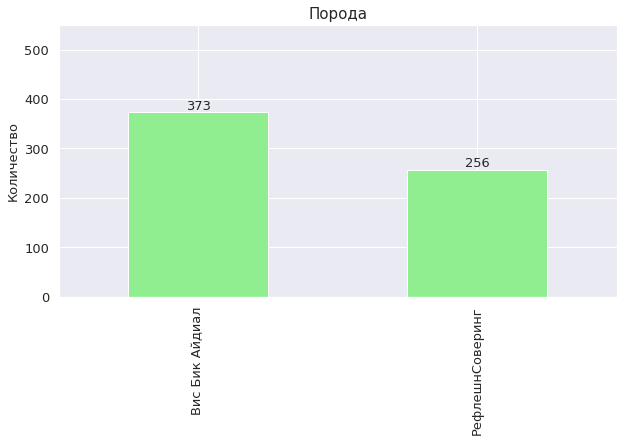

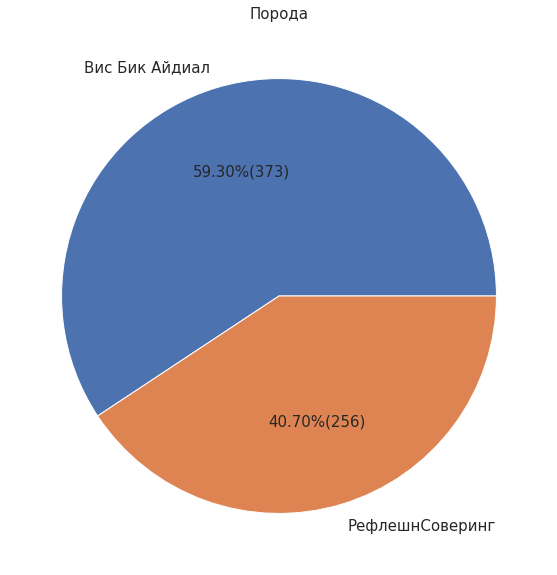

In [836]:
def category_data(column, title):
    '''Данная функция берет на себя функцию построения столбчатой и круговой диаграммы, 
    для определния распределения и доли. 
    Аргументы:
    column - выбор столбца для построения графиков
    title - название графика'''
    
    data_cat_graf = data_full[column].value_counts()

    plt.figure(figsize=(10,5))
    data_cat_graf.plot(kind='bar', color='lightgreen', fontsize=13)

    for i, val in enumerate(data_cat_graf.values):
        plt.text(i, val, int(val),
                 horizontalalignment='center', 
                 verticalalignment='bottom', 
                 fontdict={'fontweight':500, 'size':13},
                 )

    plt.title(title, fontsize=15)
    plt.ylabel('Количество',fontsize=13)
    plt.ylim(0,550)
    plt.show()
    
    plt.title(title, fontsize=15)
    data_cat_graf.plot(kind='pie', figsize =(10,10), fontsize=15,
                       autopct=lambda p: '{:.2f}%({:.0f})'.format(p,(p/100)*data_cat_graf.sum()))
    plt.ylabel('')
    
category_data('breed', 'Порода')

Распределение по типам пород бурёнок 60% на 40% в пользу Вис Бик Айдиал.

**Проверим типы пастбищ**

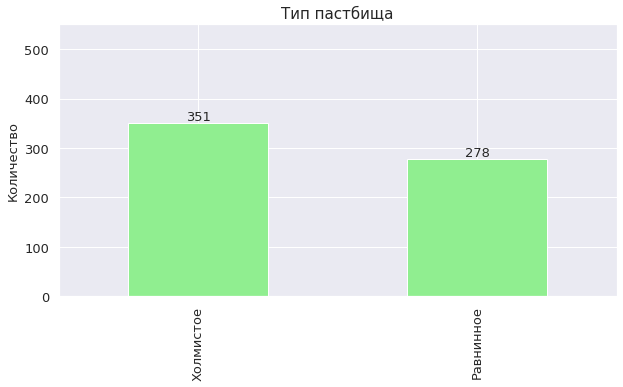

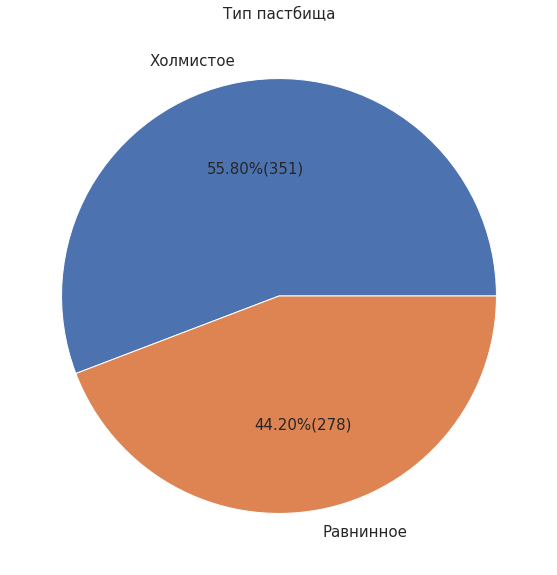

In [837]:
category_data('pasture_type', 'Тип пастбища')

Распределение по типам пастбищей 56% на 44% в пользу Холмистого

**Проверим данные о породе папы быка**

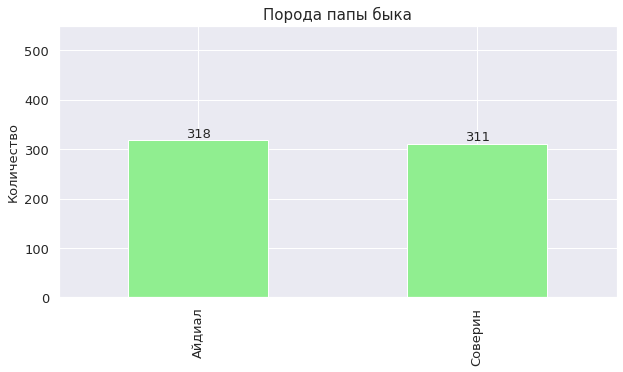

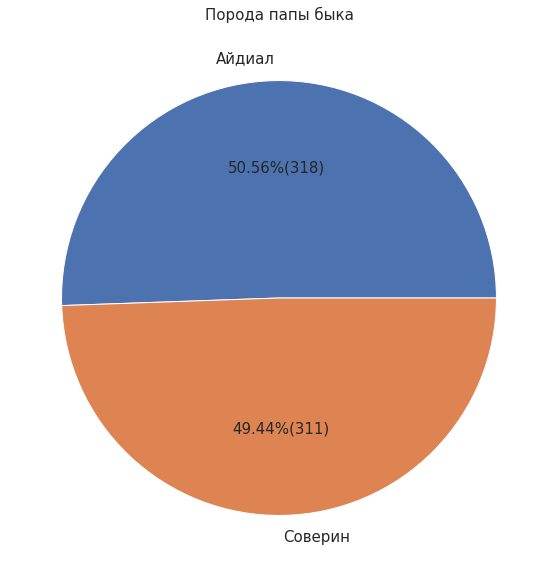

In [838]:
category_data('daddys_breed', 'Порода папы быка')

Распределение по породе папы быка фактически 50% на 50%

**Проверим данные о вкусе молока от данных бурёнок**

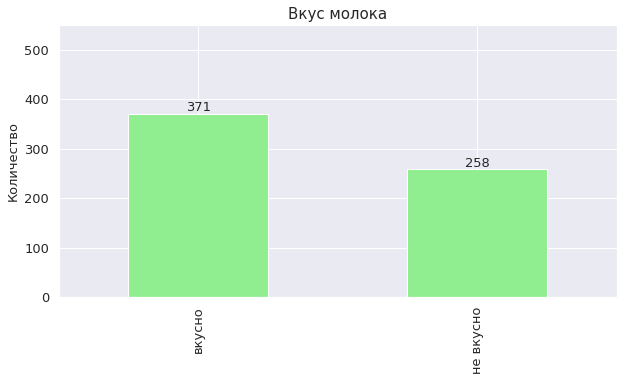

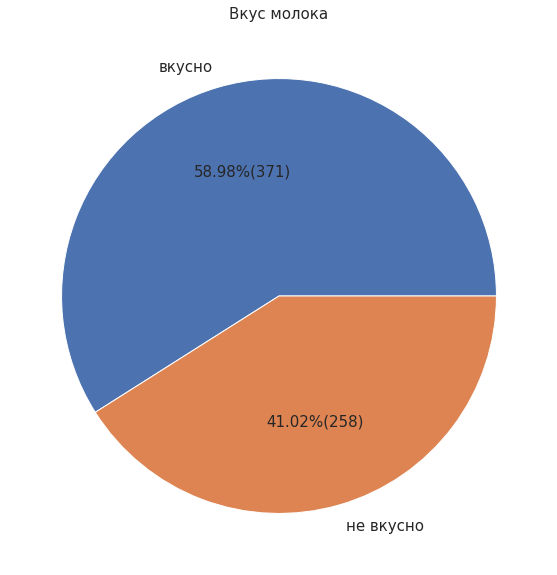

In [839]:
category_data('milk_flavour', 'Вкус молока')

Вкусное молоко состовляет 60% от всех данных

**Проверим данные о возрасте бурёнок**

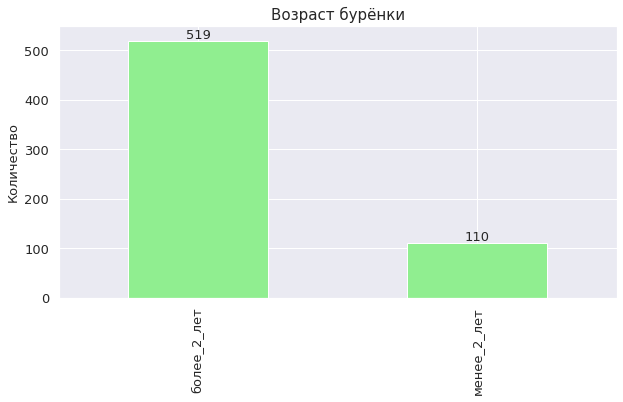

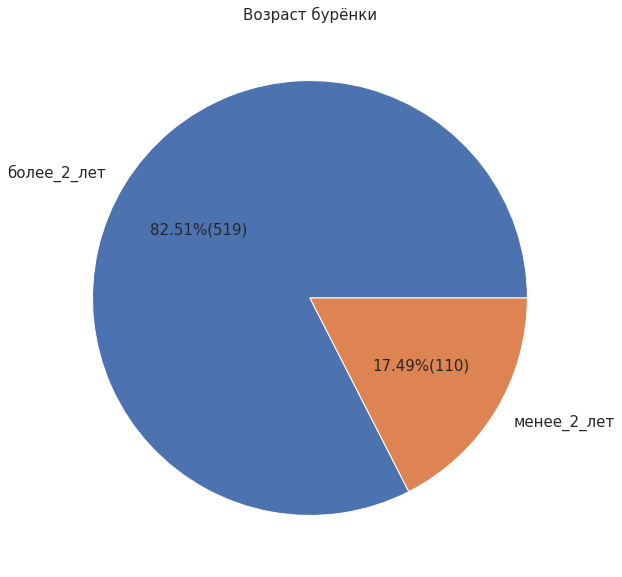

In [840]:
category_data('age', 'Возраст бурёнки')

Тут уже больше расхождений. Как мы види 82,5% составляют бурёнки старше 2-х лет

**Проверим данные о папе бурёнок**

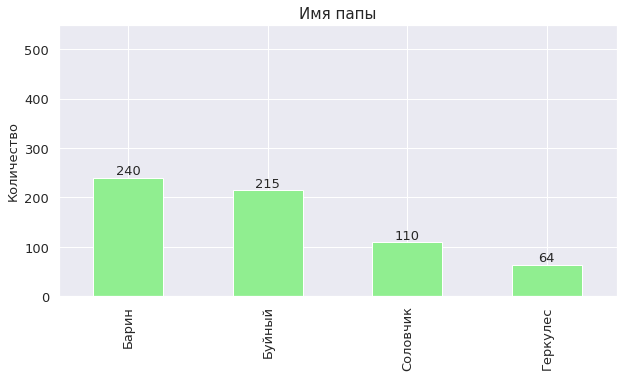

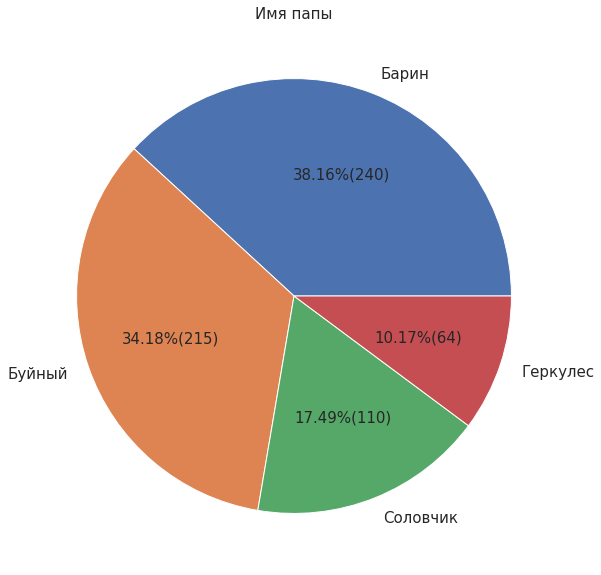

In [841]:
category_data('daddys_name', 'Имя папы')

Лидерами по плодовитости являются Барин 38% и Буйный 34%, а вот Геркулес является отцом всего 10% всех бурёнок.

В категорийных признаках распределение в основном 60% на 40%. Каких-то явных выбросов или аномалии нет, за исключением данных о возрасте, где более 80% данных это бурёнки старше 2-х лет

Теперь проверим **количественные данные**. Построим диаграммы, а также боксплоты, которые помогут выявить выбросы. Создадим функицю **number_data**, чтобы не копировать одинаковый код и начнем с показателя **объем удоя в год**

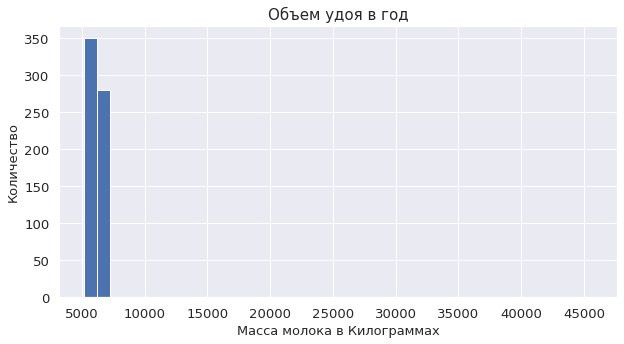

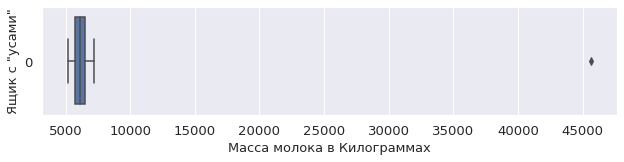

count      629.000000
mean      6188.750397
std       1644.795489
min       5204.000000
25%       5751.000000
50%       6133.000000
75%       6501.000000
max      45616.000000
Name: milk_yield, dtype: float64


In [842]:
def number_data(column, title, xlabel):
    '''Данная функция берет на себя функцию построения гистограммы, а также "Ящик с усами", 
    для определния распределения и выбросов. 
    Аргументы:
    columns - выбор столбца для построения графиков
    title - название графика
    xlabel - подпись оси x'''
    
    plt.figure(figsize=(10,5))
    data_full[column].hist(bins=40)
    plt.title(title, fontsize=15)
    plt.xlabel(xlabel,fontsize=13)
    plt.ylabel('Количество',fontsize=13)
    plt.show()
    
    plt.figure(figsize=(10.3, 2))
    sns.boxplot(data=data_full[column], orient='h')
    plt.xlabel(xlabel,fontsize=13)
    plt.ylabel('Ящик с "усами"',fontsize=13)
    plt.show()
    
    print(data_full[column].describe())

number_data('milk_yield', 'Объем удоя в год', 'Масса молока в Килограммах')

Как мы видим существует выброс. Взглянем на него подробнее

In [843]:
data_full[data_full['milk_yield'] > 10000]

,id,milk_yield,efu,raw_protein,spr,breed,pasture_type,daddys_breed,fatness,protein,milk_flavour,age,daddys_name
16,17,45616,11.5,1675,0.93,Вис Бик Айдиал,Холмистое,Айдиал,3.22,3.076,вкусно,более_2_лет,Буйный


Поскольку мы не можем уточнить, почему у этой бурёнки такое большое количество молока, то мы удалим данную строчку. Как вариант можно было бы уменьшить данный показатель в 10 раз, но мы не будем этого делать, так как новое значение в 4561 на 650 меньше самого минимального значения в датафрейме и удаление одного столбца не повредит нашему исследованию

In [844]:
data_full = data_full[data_full['milk_yield'] < 10000]

Теперь проверим данные еще раз

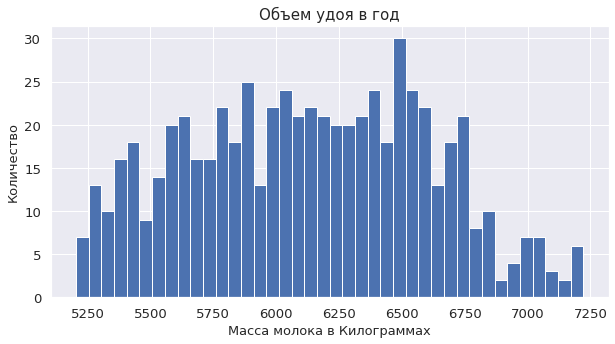

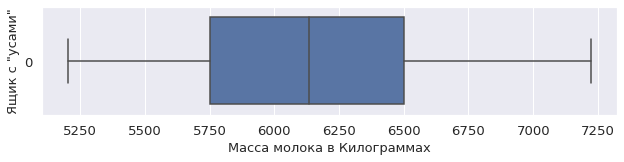

count     628.000000
mean     6125.968153
std       475.857053
min      5204.000000
25%      5749.750000
50%      6132.500000
75%      6501.000000
max      7222.000000
Name: milk_yield, dtype: float64


In [845]:
number_data('milk_yield', 'Объем удоя в год', 'Масса молока в Килограммах')

Половина всех бурёнок дают молоко в объеме от 5750 до 6500 кг в год и среднее значение почти равноудалено от границ ящика и усов. Выброс утсранили, можем перейти к следующему показателю

**Проверим показатель ЭКЕ (Энергетическая кормовая единица)**

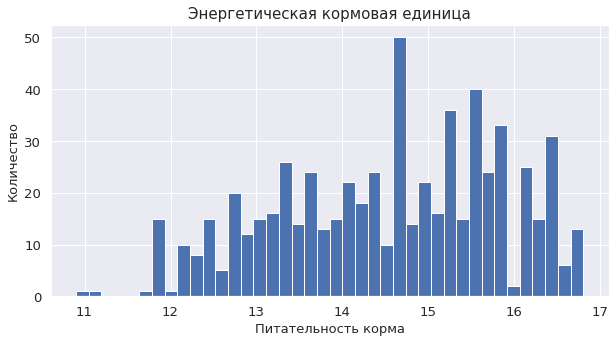

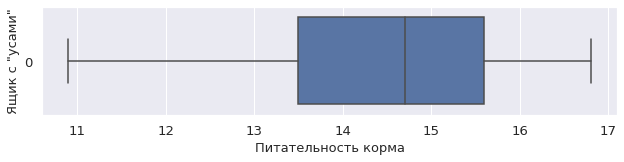

count    628.000000
mean      14.548726
std        1.301777
min       10.900000
25%       13.500000
50%       14.700000
75%       15.600000
max       16.800000
Name: efu, dtype: float64


In [846]:
number_data('efu', 'Энергетическая кормовая единица', 'Питательность корма')

Среднее смещено в большую сторону, но визуально все хорошо и выбросов нет

**Проверим показатель Сырого протеина в корме**

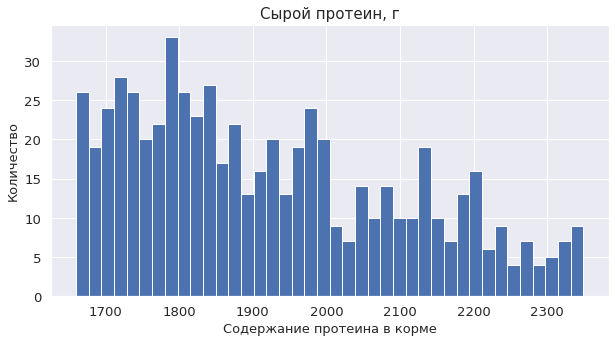

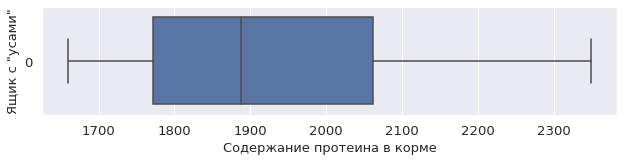

count     628.000000
mean     1923.759554
std       182.832816
min      1660.000000
25%      1771.750000
50%      1888.000000
75%      2062.250000
max      2349.000000
Name: raw_protein, dtype: float64


In [847]:
number_data('raw_protein', 'Сырой протеин, г', 'Содержание протеина в корме')

Выбросов нет, среднее содержание в размере 1888 грамм, есть небольшое смещение средней к минимальному значению

**Проверим показатель СПО (Сахаро-протеиновое соотношение)**

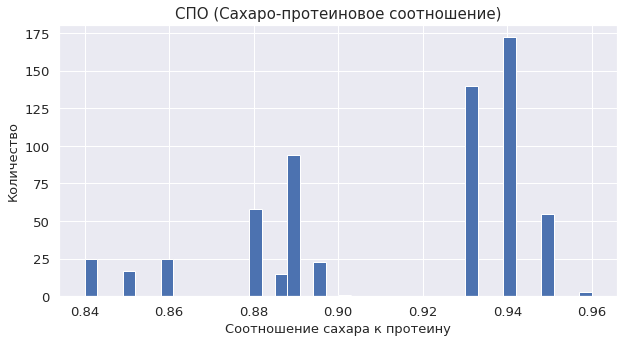

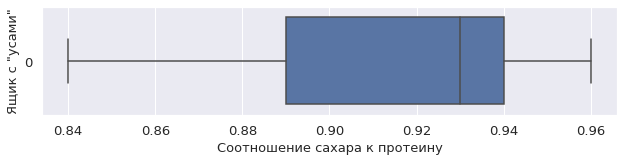

count    628.000000
mean       0.913089
std        0.032221
min        0.840000
25%        0.890000
50%        0.930000
75%        0.940000
max        0.960000
Name: spr, dtype: float64


In [848]:
number_data('spr', 'СПО (Сахаро-протеиновое соотношение)', 'Соотношение сахара к протеину')

Половина значений лежит в диапазоне от 0.93 до 0.96. Выбросов нет

**Проверим показатель содержания жиров**

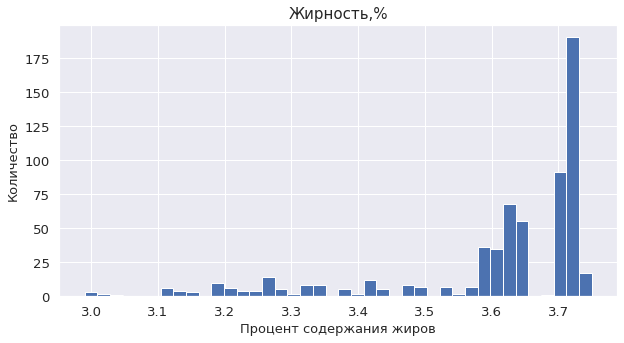

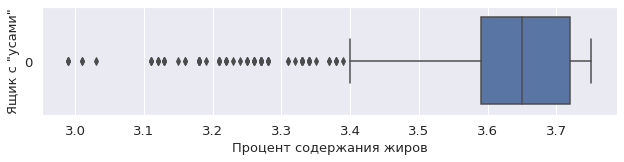

count    628.000000
mean       3.604268
std        0.168093
min        2.990000
25%        3.590000
50%        3.650000
75%        3.720000
max        3.750000
Name: fatness, dtype: float64


In [849]:
number_data('fatness', 'Жирность,%', 'Процент содержания жиров')

Как мы видим существуют выбросы в данных. Выбросы могут плохо повлиять на нашу будущую модель, однако с визуальной стороны минимальная цифра 2.99% не выглядит как выброс, поскольку более половины значений в диапазоне от 3.65% до 3.75%. К тому же удаление этих выбросов может повлиять сильнее на модель, так как может быть зависимость между данными показателями, а так мы испортим данные 

**Проверим показатель содержания белков**

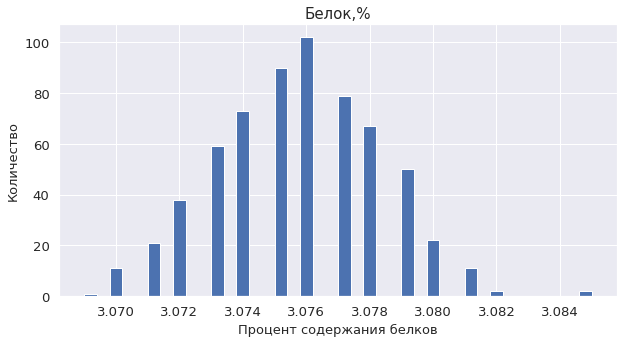

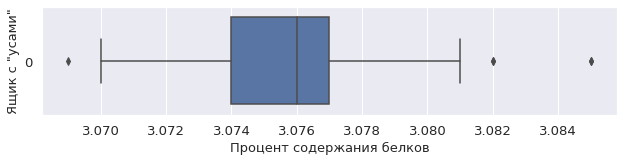

count    628.000000
mean       3.075670
std        0.002551
min        3.069000
25%        3.074000
50%        3.076000
75%        3.077000
max        3.085000
Name: protein, dtype: float64


In [850]:
number_data('protein', 'Белок,%', 'Процент содержания белков')

Как мы видим график похож на график нормального распределения. Выбросы тоже удалять не будем, поскольку у нас маленькое стандартное отклонение, поэтому 3.069% является выбросом при среднем в 3.076%.

На этапе исследовательского анализа была проделана работа по поиску аномалии (1 выброс был удален), а также первичный анализ наших данных. Можно заметить что:
- Большинство категорийных признаков имеют 2 подвида
- Большинство распределении категорийных признаков идет в разрезе 60% на 40%. Исключение возраст бурёнки. Там распределение 80% на 20%
- Среднее по удою в год лежит выше нашего порога в 6000 кг в год.
- Данные были почти без выбросов, а те выбросы что были оставлены не являются аномалиями.

## Шаг 4: Корреляционный анализ

Начнем наш анализ с составления корреляции всех признаков, а также общей диаграммы рассеивания

In [851]:
data_corr = data_full.drop(columns = 'id', axis=1)

<AxesSubplot:>

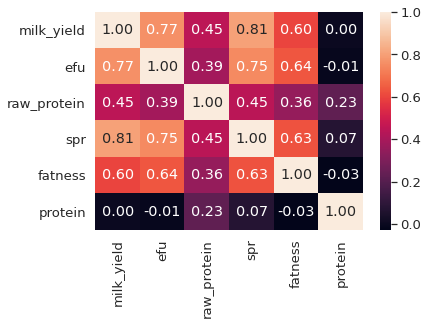

In [852]:
sns.heatmap(data_corr.corr(), annot=True, fmt='.2f') 

Одна из задач нашей будущей модели МО это создание модели расчитывающей удой молока. Как мы видим белок почти не влияет на данный показатель, а вот другие показатели в особенности ЭКЕ (Энергетическая кормовая единица) и СПО (Сахаро-протеиновое соотношение) имеют высокий коеффициент корреляции по Шкале Чеддока

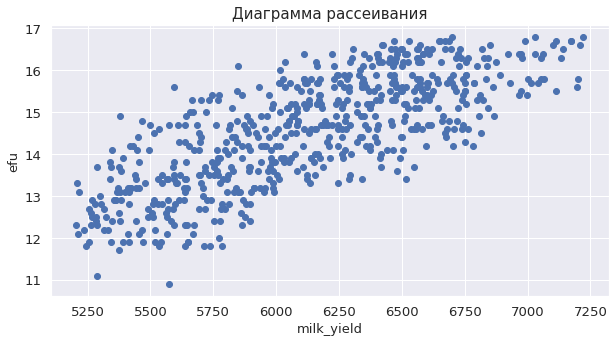

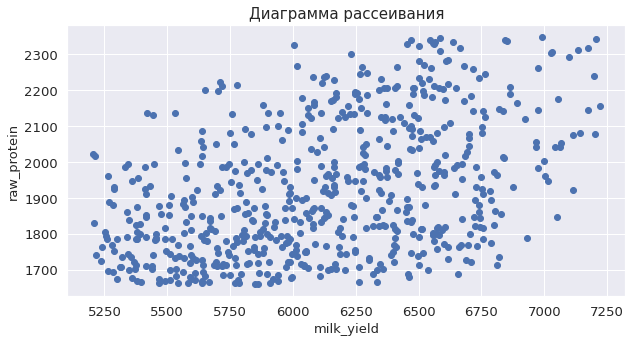

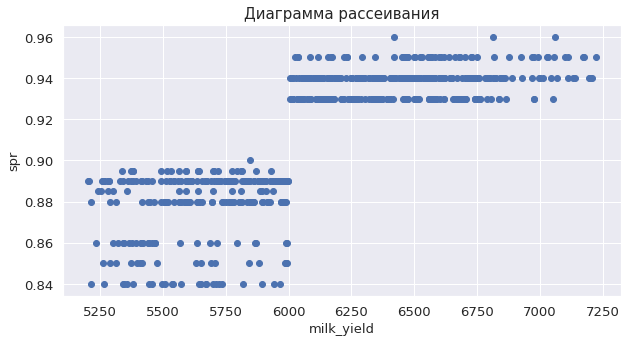

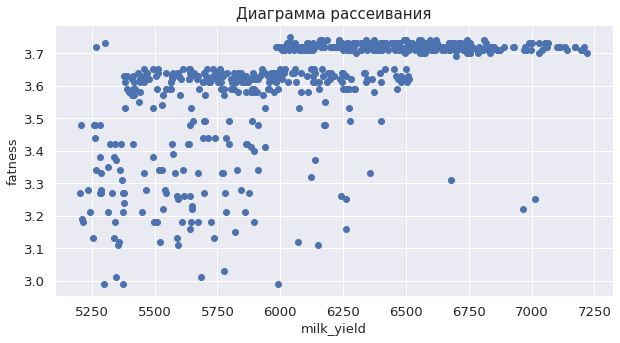

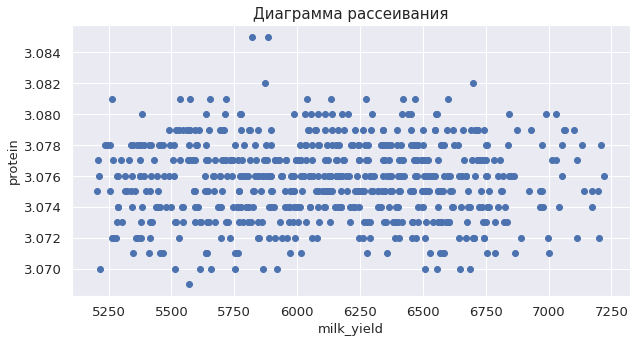

In [853]:
data_scatter = ['efu', 'raw_protein', 'spr', 'fatness', 'protein']
for i in data_scatter:
    plt.figure(figsize=(10, 5))
    plt.scatter(data_full['milk_yield'], data_full[i])
    plt.title('Диаграмма рассеивания', fontsize=15)
    plt.xlabel('milk_yield',fontsize=13)
    plt.ylabel(i,fontsize=13)
    plt.show()
    

Давайте построим диаграммы рассеивания для признака удой по разным категорийным признакам. Напишем функцию **corr_data**, чтобы не повторять однотипный код. В него мы заложим параметры на вход количественных признаков и построим графики сразу для всех категорийных признаков

Начнем со сравнения удоя с **ЭКЕ (Энергетическая кормовая единица)**

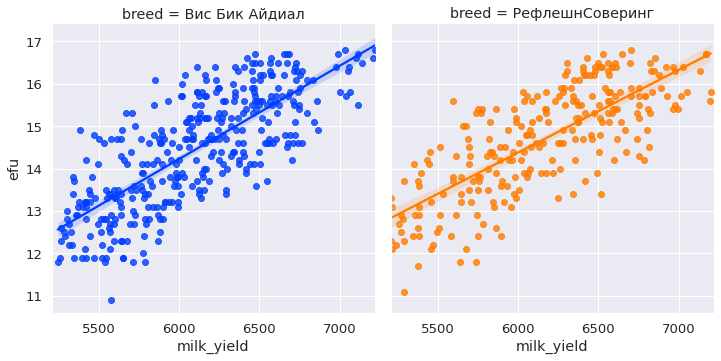

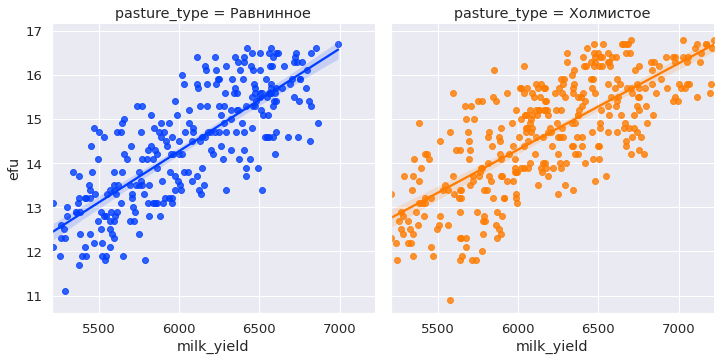

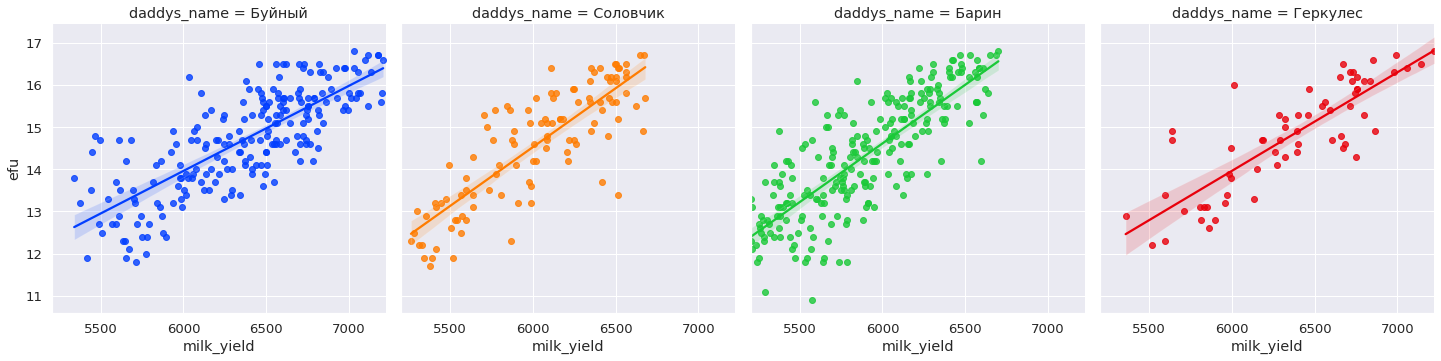

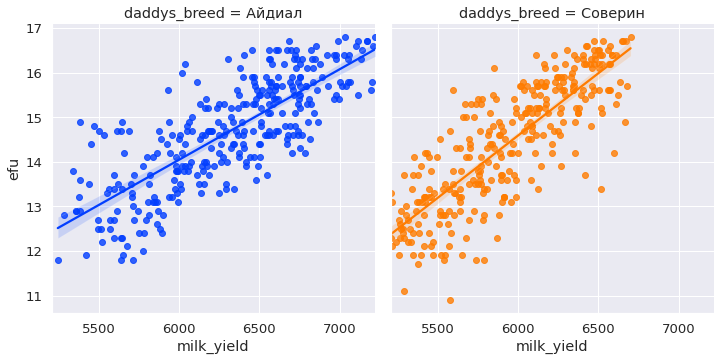

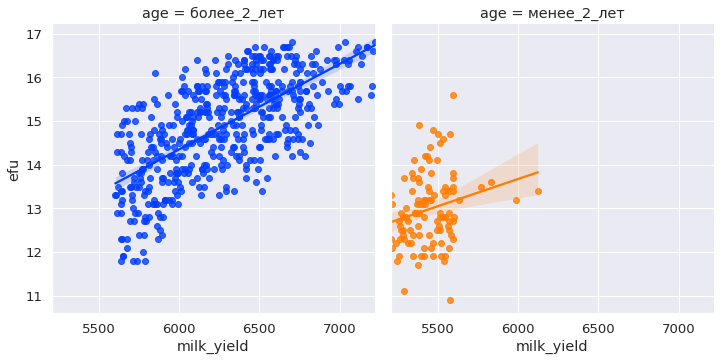

In [854]:
def corr_data(x, y):
    '''Данная функция берет на себя построение диаграммы рассеивания, 
    для определния линейности и зависимости признаков. 
    Аргументы:
    x - выбор столбца для оси X
    y - выбор столбца для оси Y'''
    
    for i in data_buy_columns:
        sns.set(font_scale=1.2)
        sns.lmplot(x=x, 
                   y=y, data=data_full, 
                   palette='bright', 
                   col=i, 
                   hue=i);
        plt.show()
    
corr_data('milk_yield', 'efu')  

Как мы видим данные по породе имеют одинаковую тенденцию почти по всем категориальным признакам. Однако стоит заметить, что возраст играет большую роль и для удоя лучше подходят бурёнки старше 2-х лет. Также можно заметить некоторое "ограничение" для породы отца "Соверин" и тех кто рос на "равнине". У них есть ограничение в 7000 кг молока в год.

Теперь проверим корреляцию на содержание **Сырого протеина**

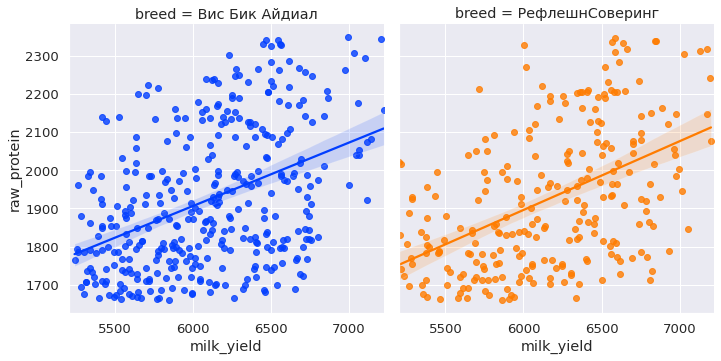

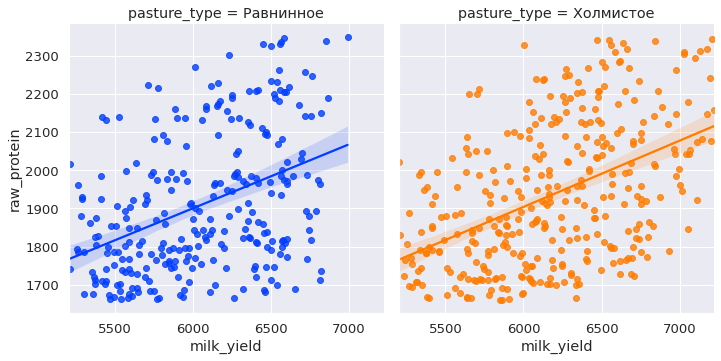

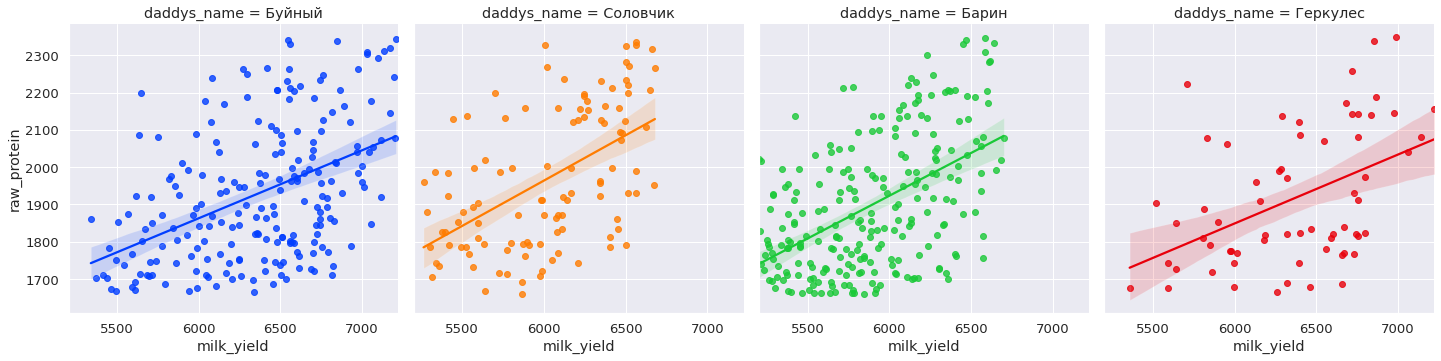

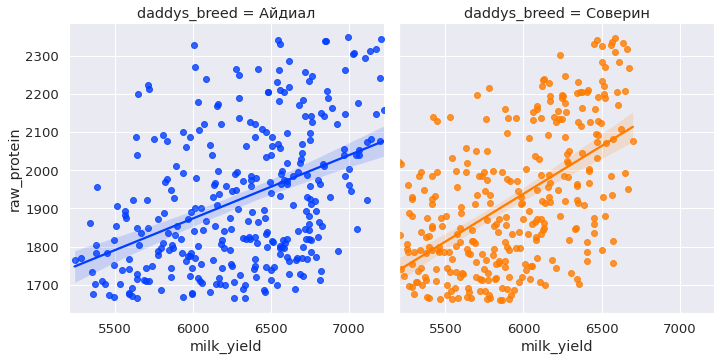

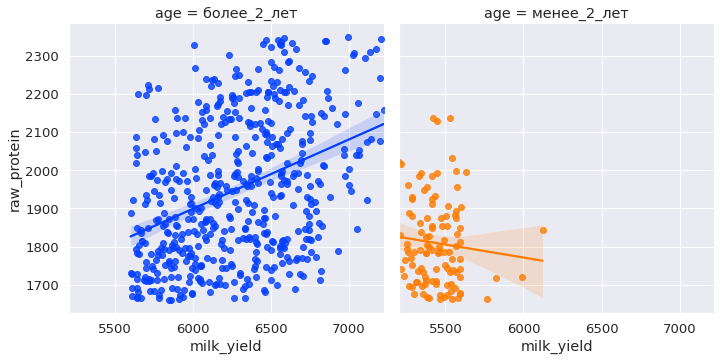

In [855]:
corr_data('milk_yield', 'raw_protein')

На данных графиках можно заметить разную тенденцию для возроста бурёнки, что означает нелинейную связь в данном признаке. В остальном тенденции похожи

Проверим данные по **СПО (Сахаро-протеиновое соотношение)**

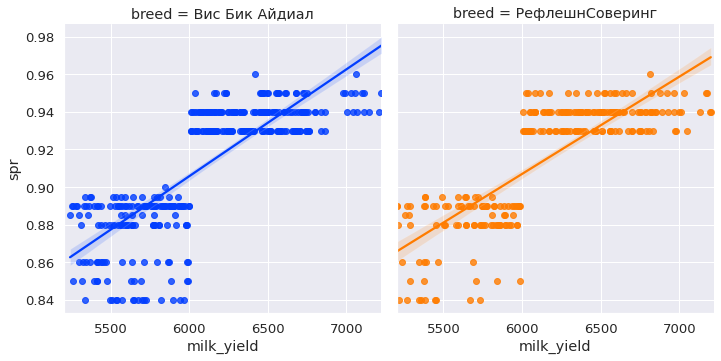

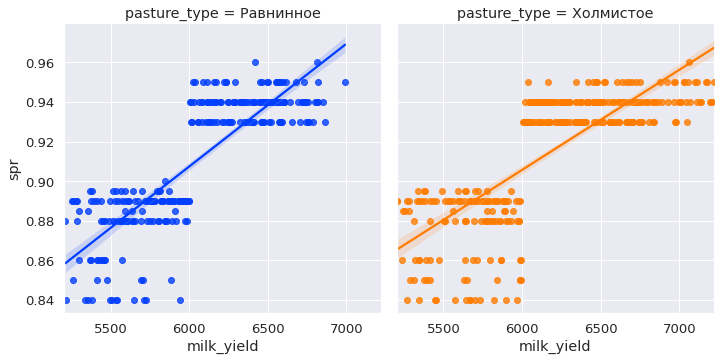

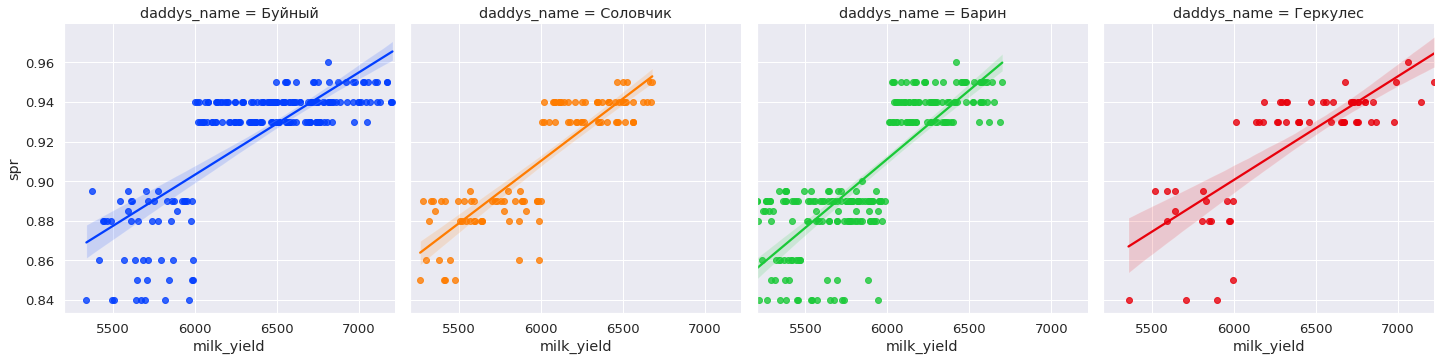

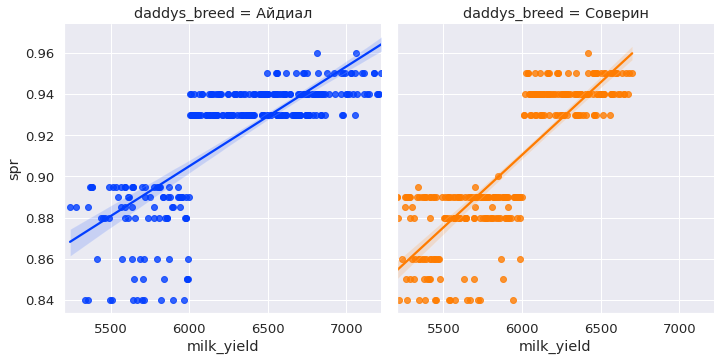

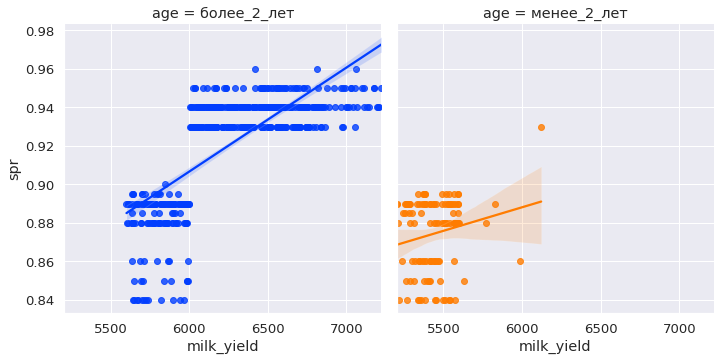

In [856]:
corr_data('milk_yield', 'spr')

Как мы видим существует визуальные границы для данного показателя. Возьмем это на заметку, так как такое распределение можно привести к булеву типу, что может как улучшить, так и ухудшить нашу модель

Проверим показатель **Жирности**

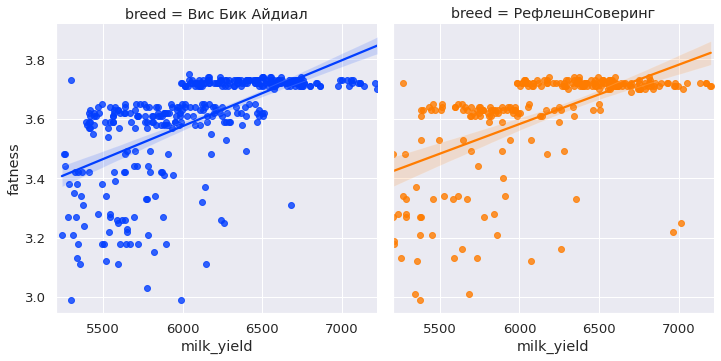

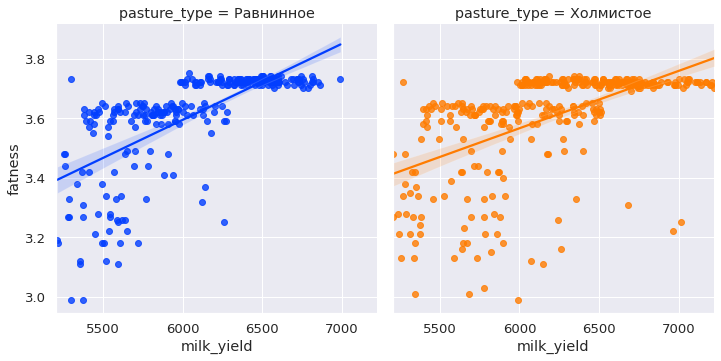

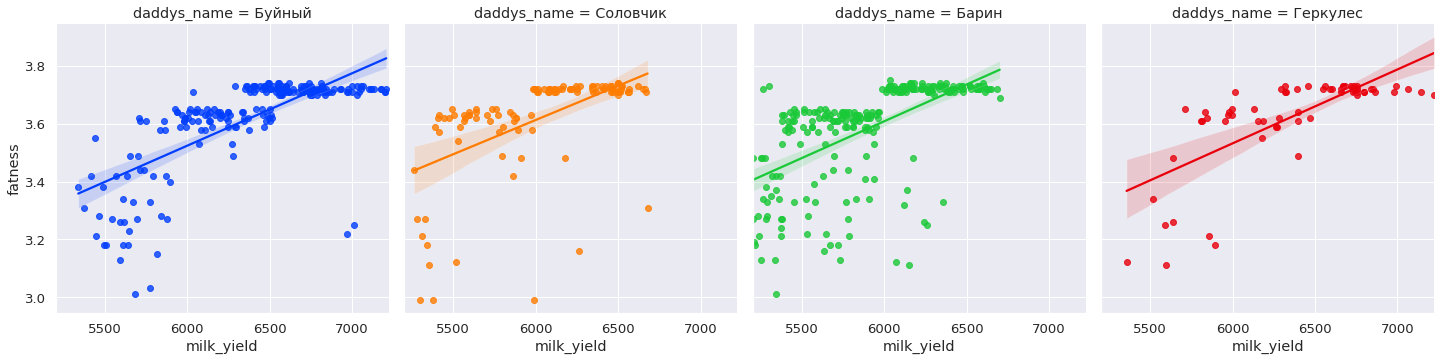

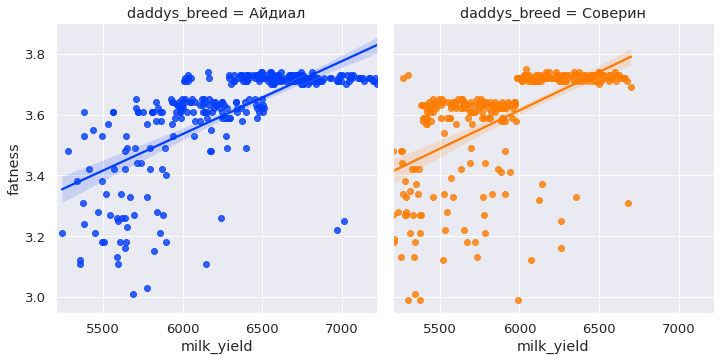

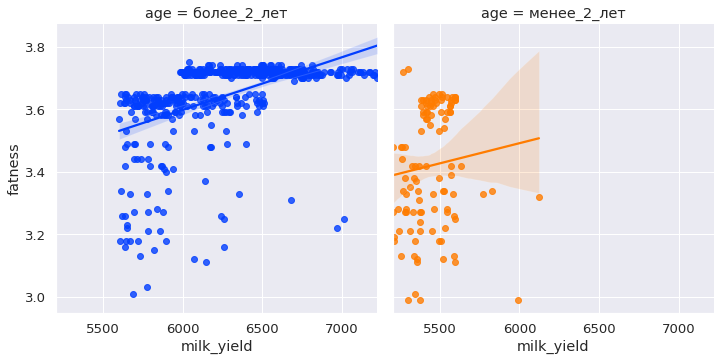

In [857]:
corr_data('milk_yield', 'fatness')

Наблюдается линейная зависимость между данными показателями. Причем для любого категорийного признака увеличенная жирность показатель увеличенного удоя молока

Провеим показатель **Белка**

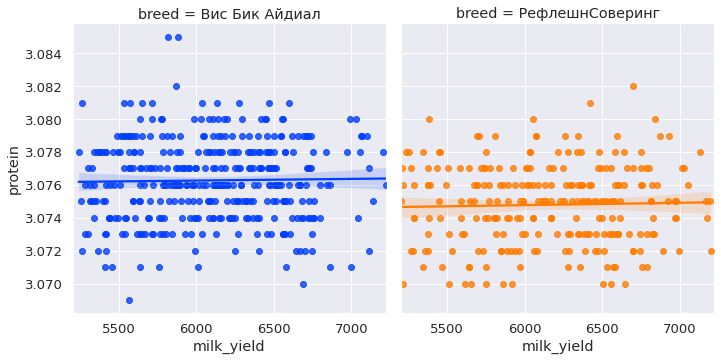

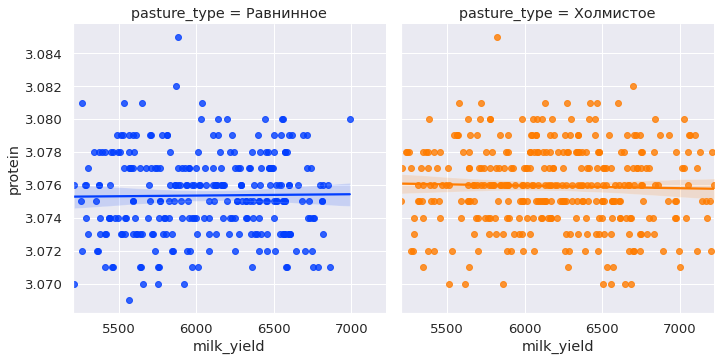

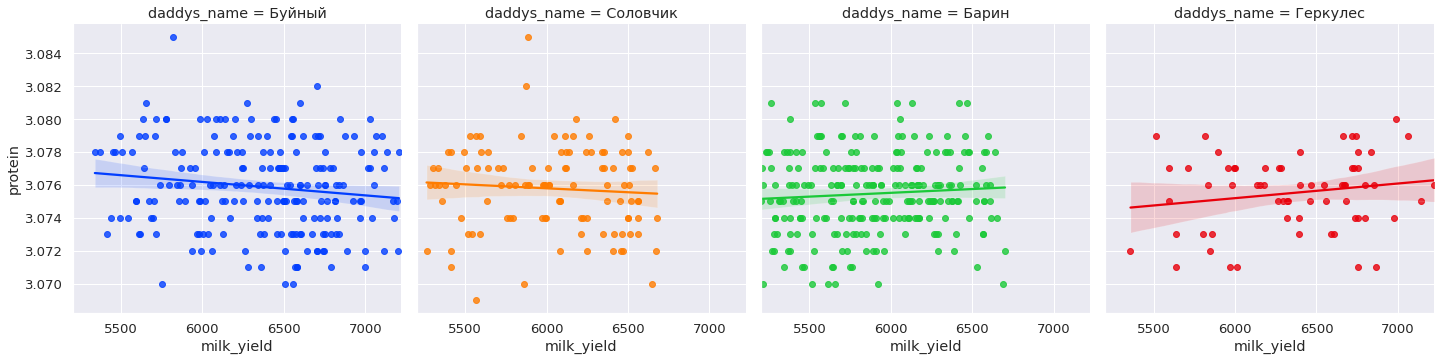

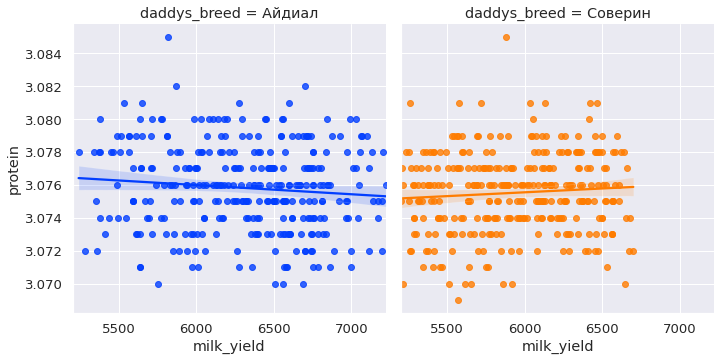

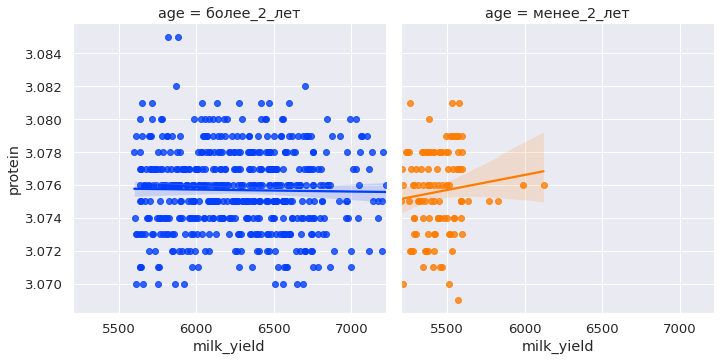

In [858]:
corr_data('milk_yield', 'protein')

Как и на матрице корреляции, данный показатель не имеет линейной зависимости.

На основе корреляционного анализа, можно сделать некоторые промежуточные выводы:
- Основная линейная зависимость для удоя это Кормовые харакетистики (ЭКЕ, Сырой протеин и СПО).
- Отсутствие корреляции у удоя и содержания белка в молоке.
- Наибольший объем молока дают бурёнки старше 2-х лет.
- Чем больше жирность у молока, тем больший объем в год может дать бурёнка.
- Можно обратить внимание на квадратичную зависимость между ЭКЕ и удоем, а также кластеризацию для параметра СПО. Это может помочь улучшить нашу модель

## Шаг 5: Обучение модели линейной регрессии

Предположим, что у нас не было данных с именем отца бурёнки. Начем делать модель с датасетом data_main. Поскольку мы избавились от одного выброса, после объединения двух датафреймов, то удалим этот выброс и здесь.

In [859]:
data_main = data_main[data_main['milk_yield'] < 10000]

Создавать модель и работать с ней лучше в одной ячейке с кодом, поскольку если вынести константу random_state в отдельный блок, то придется перезапускать несколько ячеек, чтобы она применялась. Также, я изменю стиль комментариев и буду писать их в коде, чтобы комментарии шли перед кодом, а не общим потоком после него.

R2 первой модели = 0.784
MAE первой модели = 173
RMSE первой модели = 48067
MSE первой модели = 219


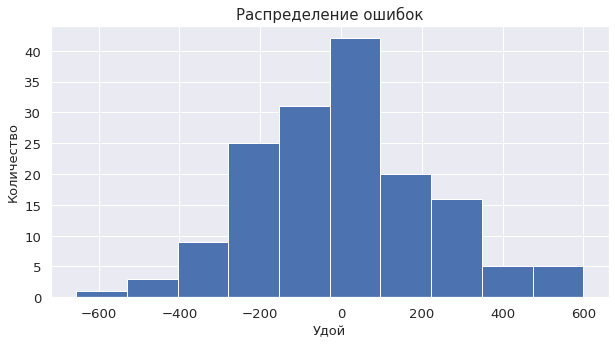

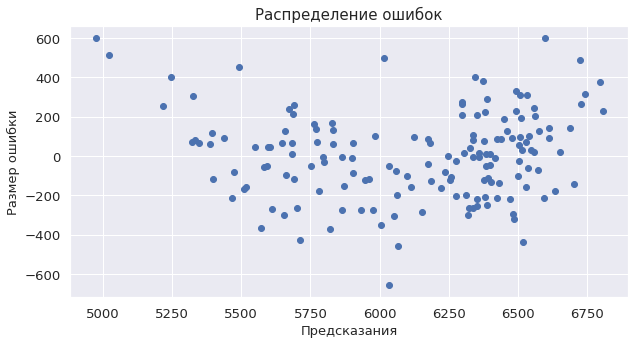

In [860]:
# создадим константу, чтобы выборка не менялась и модель работала на одной базе.
RANDOM_STATE = 66

# выделим в отдельные переменные целевой признак и входные признаки
X = data_main.drop(['milk_yield'], axis=1)
y = data_main['milk_yield']

# делим данные на тестовую и основную выборку, а также фиксируем нашу константу
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = RANDOM_STATE)

# создадим список категориальных признаков тренировочной выборки.
# из категорийных принаков мы уберем вкус молока, так как это субъективный признак который не улучшит нашу модель
cat_col_names = ['breed', 'pasture_type', 'daddys_breed', 'age']

# создадим список количественных признаков тренировочной выборки. Удалим отсюда данные о молоке, а также соберджание протеина
# из-за низкой линейной зависимости
num_col_names = ['efu', 'spr']

# создадим переменную для маштабирования методом стандартизации
scaler = StandardScaler()

# обучим и трансформируем количественные признаки из тренировочной выборки 
X_train_scaled = scaler.fit_transform(X_train[num_col_names])

# выполним преобразование для тестовой выборки
X_test_scaled = scaler.transform(X_test[num_col_names])

# Теперь перейдем к категориальным столбцам
# создадим переменную с экземпляром класса OneHotEncoder(), а также удалим один столбец во избежинии дамми-ловушки
encoder = OneHotEncoder(drop='first', sparse=False)

# обучим и трансформируем категориальные признаки из тренировочной выборки 
X_train_ohe = encoder.fit_transform(X_train[cat_col_names]) 

# выполним преобразование для тестовой выборки
X_test_ohe = encoder.transform(X_test[cat_col_names]) 

# получим список новых столбцов
encoder_col_names = encoder.get_feature_names()

# создадим тренировочный и тестовый датафреймы из закодированных и отмасштабированных данных
X_train_ohe = pd.DataFrame(X_train_ohe, columns=encoder_col_names)
X_test_ohe = pd.DataFrame(X_test_ohe, columns=encoder_col_names)

X_train_scaled = pd.DataFrame(X_train_scaled, columns=num_col_names)
X_test_scaled = pd.DataFrame(X_test_scaled, columns=num_col_names)

# объединим все преобразованные данные в тренировочный и тестовый датафреймы
X_train = pd.concat([X_train_ohe, X_train_scaled], axis=1)
X_test = pd.concat([X_test_ohe, X_test_scaled], axis=1)

# запускаем модель линейной регрессии
model_lr  = LinearRegression()

# обучаем модель на тренировочных данных
model_lr.fit(X_train, y_train)

# получаем предсказания модели на тестовых данных
predictions = model_lr.predict(X_test)

# выведем показатели модели и ее ошибок
r2_model1 = r2_score(y_test, predictions)
mae_model1 = mean_absolute_error(y_test, predictions)
rmse_model1 = mean_squared_error(y_test, predictions,)
mse_model1 = mean_squared_error(y_test, predictions, squared=False)
residuals = y_test - predictions

# вывод полученных значений
print(f"R2 первой модели = {r2_model1:.3f}")
print(f"MAE первой модели = {mae_model1:.0f}")
print(f"RMSE первой модели = {rmse_model1:.0f}")
print(f"MSE первой модели = {mse_model1:.0f}")

# построим график распределние ошибок
plt.figure(figsize=(10,5))
residuals.hist(bins=10)
plt.title('Распределение ошибок', fontsize=15)
plt.xlabel('Удой',fontsize=13)
plt.ylabel('Количество',fontsize=13)
plt.show()

# построим диаграмму распределния ошибок
plt.figure(figsize=(10,5))
plt.scatter(predictions, residuals)
plt.title('Распределение ошибок', fontsize=15)
plt.xlabel('Предсказания',fontsize=13)
plt.ylabel('Размер ошибки',fontsize=13)
plt.show()

Как работает наша первая модель. R2 составляет 0.78, что довольно неплохой результат для первой попытки, а в абсолютах ошибается в среднем на +- 173 кг в год. Также мы видим, что распределение ошибок имеет нормальное распределение, что говорит о рабочей модели. Распределение остатков напоминает "Дугу", что говорит о ее возможном улучшений

Попробуем ее улучшить. Теперь возьмем всю базу, что у нас есть

R2 второй модели = 0.800
MAE второй модели = 165
RMSE второй модели = 44478
MSE второй модели = 211


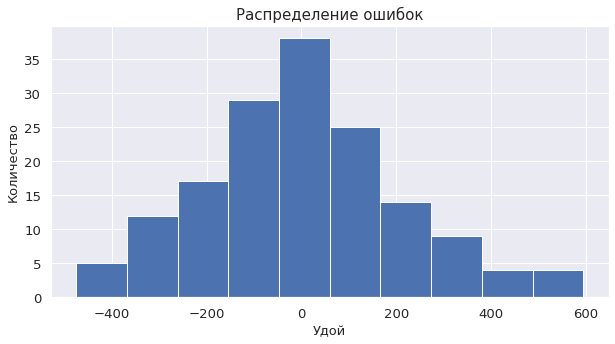

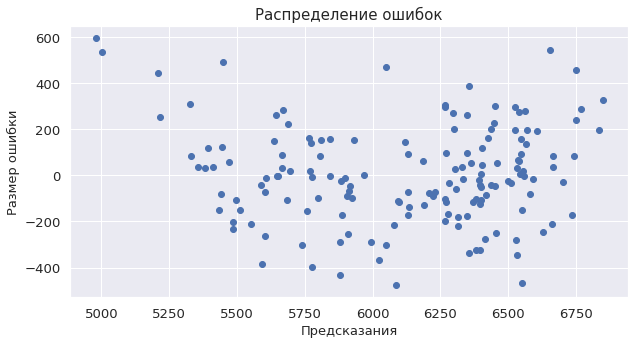

In [861]:
# создадим константу, чтобы выборка не менялась и улучшение модели было на одной базе.
RANDOM_STATE = 66

# выделим в отдельные переменные целевой признак и входные признаки
X = data_full.drop(['milk_yield'], axis=1)
y = data_full['milk_yield']

# делим данные на тестовую и основную выборку, а также фиксируем нашу константу
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = RANDOM_STATE)

# создадим список категориальных признаков тренировочной выборки.
cat_col_names = ['breed', 'pasture_type', 'daddys_breed', 'age', 'daddys_name']

# создадим список количественных признаков тренировочной выборки
num_col_names = ['efu', 'spr']

# создадим переменную для маштабирования методом стандартизации
scaler = StandardScaler()

# обучим и трансформируем количественные признаки из тренировочной выборки 
X_train_scaled = scaler.fit_transform(X_train[num_col_names])

# выполним преобразование для тестовой выборки
X_test_scaled = scaler.transform(X_test[num_col_names])

# Теперь перейдем к категориальным столбцам
# создадим переменную с экземпляром класса OneHotEncoder(), а также удалим один столбец во избежинии дамми-ловушки
encoder = OneHotEncoder(drop='first', sparse=False)

# обучим и трансформируем категориальные признаки из тренировочной выборки 
X_train_ohe = encoder.fit_transform(X_train[cat_col_names]) 

# выполним преобразование для тестовой выборки
X_test_ohe = encoder.transform(X_test[cat_col_names]) 

# получим список новых столбцов
encoder_col_names = encoder.get_feature_names()

# создаём тренировочный и тестовый датафреймы из закодированных и отмасштабированных данных
X_train_ohe = pd.DataFrame(X_train_ohe, columns=encoder_col_names)
X_test_ohe = pd.DataFrame(X_test_ohe, columns=encoder_col_names)

X_train_scaled = pd.DataFrame(X_train_scaled, columns=num_col_names)
X_test_scaled = pd.DataFrame(X_test_scaled, columns=num_col_names)

# объединяем все преобразованные данные в тренировочный и тестовый датафреймы
X_train = pd.concat([X_train_ohe, X_train_scaled], axis=1)
X_test = pd.concat([X_test_ohe, X_test_scaled], axis=1)

# запускаем модель линейной регрессии
model_lr  = LinearRegression()

# обучаем модель на тренировочных данных
model_lr.fit(X_train, y_train)

# получаем предсказания модели на тестовых данных
predictions = model_lr.predict(X_test)

# выведем показатели модели и ее ошибок
r2_model2 = r2_score(y_test, predictions)
mae_model2 = mean_absolute_error(y_test, predictions)
rmse_model2 = mean_squared_error(y_test, predictions,)
mse_model2 = mean_squared_error(y_test, predictions, squared=False)
residuals = y_test - predictions

# вывод полученных значений
print(f"R2 второй модели = {r2_model2:.3f}")
print(f"MAE второй модели = {mae_model2:.0f}")
print(f"RMSE второй модели = {rmse_model2:.0f}")
print(f"MSE второй модели = {mse_model2:.0f}")

# построим график распределние ошибок
plt.figure(figsize=(10,5))
residuals.hist(bins=10)
plt.title('Распределение ошибок', fontsize=15)
plt.xlabel('Удой',fontsize=13)
plt.ylabel('Количество',fontsize=13)
plt.show()

# построим диаграмму распределния ошибок
plt.figure(figsize=(10,5))
plt.scatter(predictions, residuals)
plt.title('Распределение ошибок', fontsize=15)
plt.xlabel('Предсказания',fontsize=13)
plt.ylabel('Размер ошибки',fontsize=13)
plt.show()

Добавление одного категорийного признака 'daddys_name' улучшило нашу модель увеличив ее точность (R2 - 0,8), а также уменьшив среднее отклонение на +-163 кг. Распределение ошибок все еще имеет нормальное распределение и распрделение остатков столо лучше, так что нашу модель мы улучшили. Но попробуем сделать еще одну вещь, которую мы заметили во время корреляционного анализа.

До этого мы видели данные по СПО (Сахаро-протеиновое соотношение). Они визуально разделены на 2 кластера. Попробуем улучшить этот признак для нашей модели сделав его бинарным, а также попробуем улучшить признак ЭКЕ для нашей модели, а для этого возведем его в квадрат

In [862]:
data_for_model3 = data_full.drop(columns = 'id', axis=1)
data_for_model3['efu'] = data_for_model3['efu'] ** 2
data_for_model3['spr'] = data_for_model3['spr'].apply(lambda x: 1 if x>= 0.92 else 0)
data_for_model3.head(10)

,milk_yield,efu,raw_protein,spr,breed,pasture_type,daddys_breed,fatness,protein,milk_flavour,age,daddys_name
0,5863,201.64,1743,0,Вис Бик Айдиал,Равнинное,Айдиал,3.58,3.076,вкусно,более_2_лет,Буйный
1,5529,163.84,2138,0,Вис Бик Айдиал,Равнинное,Соверин,3.54,3.079,вкусно,менее_2_лет,Соловчик
2,5810,196.00,1854,0,РефлешнСоверинг,Холмистое,Соверин,3.59,3.074,не вкусно,более_2_лет,Барин
3,5895,153.76,2012,0,РефлешнСоверинг,Холмистое,Айдиал,3.40,3.075,не вкусно,более_2_лет,Буйный
4,5302,163.84,1675,0,Вис Бик Айдиал,Равнинное,Соверин,3.73,3.073,вкусно,менее_2_лет,Барин
5,5254,161.29,1806,0,РефлешнСоверинг,Холмистое,Соверин,3.13,3.078,вкусно,менее_2_лет,Барин
6,5910,174.24,1792,0,Вис Бик Айдиал,Равнинное,Соверин,3.48,3.077,вкусно,более_2_лет,Соловчик
7,6179,216.09,1806,1,Вис Бик Айдиал,Равнинное,Айдиал,3.55,3.076,вкусно,более_2_лет,Геркулес
8,6783,201.64,1918,1,РефлешнСоверинг,Холмистое,Айдиал,3.71,3.077,вкусно,более_2_лет,Буйный
9,5339,179.56,1791,0,Вис Бик Айдиал,Холмистое,Соверин,3.13,3.075,вкусно,менее_2_лет,Барин


Проверим нашу 3-ую модель

R2 третей модели = 0.826
MAE третей модели = 160
RMSE третей модели = 38855
MSE третей модели = 197


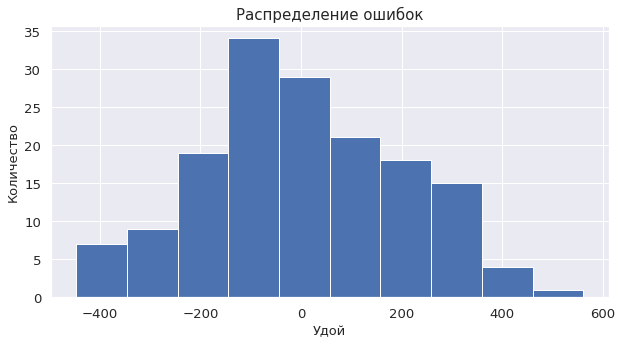

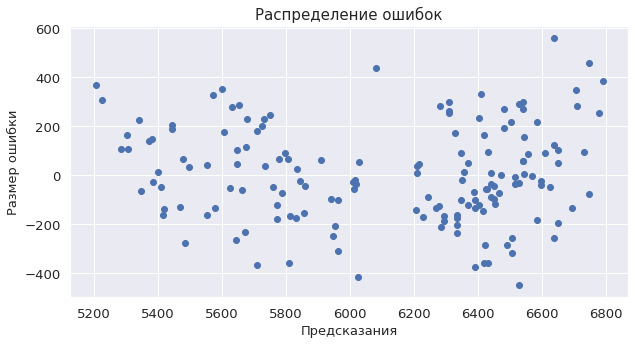

In [863]:
# создадим константу, чтобы выборка не менялась и улучшение модели было на одной базе.
RANDOM_STATE = 66

# выделим в отдельные переменные целевой признак и входные признаки
X = data_for_model3.drop(['milk_yield'], axis=1)
y = data_for_model3['milk_yield']

# делим данные на тестовую и основную выборку, а также фиксируем нашу константу
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = RANDOM_STATE)

# создадим список категориальных признаков тренировочной выборки.
cat_col_names = ['breed', 'pasture_type', 'daddys_breed', 'age', 'daddys_name', 'spr']

# создадим список количественных признаков тренировочной выборки.
num_col_names = ['efu']

# создадим переменную для маштабирования методом стандартизации
scaler = StandardScaler()

# обучим и трансформируем количественные признаки из тренировочной выборки 
X_train_scaled = scaler.fit_transform(X_train[num_col_names])

# выполним преобразование для тестовой выборки
X_test_scaled = scaler.transform(X_test[num_col_names])

# Теперь перейдем к категориальным столбцам
# создадим переменную с экземпляром класса OneHotEncoder(), а также удалим один столбец во избежинии дамми-ловушки
encoder = OneHotEncoder(drop='first', sparse=False)

# обучим и трансформируйте категориальные признаки из тренировочной выборки 
X_train_ohe = encoder.fit_transform(X_train[cat_col_names]) 

# выполним преобразование для тестовой выборки
X_test_ohe = encoder.transform(X_test[cat_col_names]) 

# получим список новых столбцов
encoder_col_names = encoder.get_feature_names()

# создаём тренировочный и тестовый датафреймы из закодированных и отмасштабированных данных
X_train_ohe = pd.DataFrame(X_train_ohe, columns=encoder_col_names)
X_test_ohe = pd.DataFrame(X_test_ohe, columns=encoder_col_names)

X_train_scaled = pd.DataFrame(X_train_scaled, columns=num_col_names)
X_test_scaled = pd.DataFrame(X_test_scaled, columns=num_col_names)

# объединяем все преобразованные данные в тренировочный и тестовый датафреймы
X_train = pd.concat([X_train_ohe, X_train_scaled], axis=1)
X_test = pd.concat([X_test_ohe, X_test_scaled], axis=1)

# запускаем модель линейной регрессии
model_lr  = LinearRegression()

# обучаем модель на тренировочных данных
model_lr.fit(X_train, y_train)

# получаем предсказания модели на тестовых данных
predictions = model_lr.predict(X_test)

# выведем показатели модели и ее ошибок
r2_model3 = r2_score(y_test, predictions)
mae_model3 = mean_absolute_error(y_test, predictions)
rmse_model3 = mean_squared_error(y_test, predictions,)
mse_model3 = mean_squared_error(y_test, predictions, squared=False)
residuals = y_test - predictions

# вывод полученных значений
print(f"R2 третей модели = {r2_model3:.3f}")
print(f"MAE третей модели = {mae_model3:.0f}")
print(f"RMSE третей модели = {rmse_model3:.0f}")
print(f"MSE третей модели = {mse_model3:.0f}")

# построим график распределние ошибок
plt.figure(figsize=(10,5))
residuals.hist(bins=10)
plt.title('Распределение ошибок', fontsize=15)
plt.xlabel('Удой',fontsize=13)
plt.ylabel('Количество',fontsize=13)
plt.show()


# построим диаграмму распределния ошибок
plt.figure(figsize=(10,5))
plt.scatter(predictions, residuals)
plt.title('Распределение ошибок', fontsize=15)
plt.xlabel('Предсказания',fontsize=13)
plt.ylabel('Размер ошибки',fontsize=13)
plt.show()

Как мы видим модель стала работать еще лучше. r2 уже 0.83, а среднее отклонение +- 160 кг в год. Также остатки стали менее "дугообразными" и больше похожи на постоянный разброс дисперсии.

В целом можно пытаться еще улучшать эту модель, но остановимся на этом варианте.

Давайте посмотрим на доверительный интервал этой модели

In [864]:
print(predictions.mean())
st.norm.interval(0.95, loc=np.mean(predictions), scale=st.sem(predictions))

6114.113548003652


(6045.741820035078, 6182.485275972226)

Как мы видим доверительный интервал наших предсказаний лежит в диапазоне 6360 - 6488, что состовляет +- 60 кг в год от средних наших предсказании

Теперь давайте добавим данные для тех бурёнок, которые хочет купить наш клиент. Нам нужно сопоставить столбцы с искомым датафреймом обучающей модели. Давайте сравним данные.

In [865]:
data_for_model3.head(5)

,milk_yield,efu,raw_protein,spr,breed,pasture_type,daddys_breed,fatness,protein,milk_flavour,age,daddys_name
0,5863,201.64,1743,0,Вис Бик Айдиал,Равнинное,Айдиал,3.58,3.076,вкусно,более_2_лет,Буйный
1,5529,163.84,2138,0,Вис Бик Айдиал,Равнинное,Соверин,3.54,3.079,вкусно,менее_2_лет,Соловчик
2,5810,196.00,1854,0,РефлешнСоверинг,Холмистое,Соверин,3.59,3.074,не вкусно,более_2_лет,Барин
3,5895,153.76,2012,0,РефлешнСоверинг,Холмистое,Айдиал,3.40,3.075,не вкусно,более_2_лет,Буйный
4,5302,163.84,1675,0,Вис Бик Айдиал,Равнинное,Соверин,3.73,3.073,вкусно,менее_2_лет,Барин


In [866]:
data_buy.head(5)

,breed,pasture_type,daddys_breed,daddys_name,fatness,protein,age
0,Вис Бик Айдиал,Холмистое,Айдиал,Геркулес,3.58,3.076,более_2_лет
1,Вис Бик Айдиал,Равнинное,Соверин,Буйный,3.54,3.081,менее_2_лет
2,РефлешнСоверинг,Равнинное,Соверин,Барин,3.59,3.074,более_2_лет
3,РефлешнСоверинг,Холмистое,Айдиал,Буйный,3.40,3.061,более_2_лет
4,РефлешнСоверинг,Равнинное,Айдиал,Буйный,3.64,3.074,более_2_лет


Так как в обучающей модели мы не использовали столбцы raw_protein и milk_flavour, то нам они не нужны в выборке для коров, а вот недостfющие столбцы мы добавим средними значениями из data main, но добавим 5% к средним показателям 

In [867]:
new_columns = ['spr','raw_protein','efu', 'milk_yield']

In [868]:
for i in new_columns:
    data_buy.insert(0, i, data_main[i].mean() * 1.05, allow_duplicates=False) 

In [869]:
data_for_model3.head(5)

,milk_yield,efu,raw_protein,spr,breed,pasture_type,daddys_breed,fatness,protein,milk_flavour,age,daddys_name
0,5863,201.64,1743,0,Вис Бик Айдиал,Равнинное,Айдиал,3.58,3.076,вкусно,более_2_лет,Буйный
1,5529,163.84,2138,0,Вис Бик Айдиал,Равнинное,Соверин,3.54,3.079,вкусно,менее_2_лет,Соловчик
2,5810,196.00,1854,0,РефлешнСоверинг,Холмистое,Соверин,3.59,3.074,не вкусно,более_2_лет,Барин
3,5895,153.76,2012,0,РефлешнСоверинг,Холмистое,Айдиал,3.40,3.075,не вкусно,более_2_лет,Буйный
4,5302,163.84,1675,0,Вис Бик Айдиал,Равнинное,Соверин,3.73,3.073,вкусно,менее_2_лет,Барин


Теперь сделаем нужнные преобразования для данных покупок

In [870]:
data_prediction = data_buy.iloc[:, [0, 1, 2, 3, 4, 5, 6, 8, 9, 10, 7]]    
data_prediction['efu'] = data_prediction['efu'] ** 2
data_prediction['spr'] = data_prediction['spr'].apply(lambda x: 1 if x>= 0.92 else 0)
data_prediction.head(5)

,milk_yield,efu,raw_protein,spr,breed,pasture_type,daddys_breed,fatness,protein,age,daddys_name
0,6432.266561,233.361138,2019.947532,1,Вис Бик Айдиал,Холмистое,Айдиал,3.58,3.076,более_2_лет,Геркулес
1,6432.266561,233.361138,2019.947532,1,Вис Бик Айдиал,Равнинное,Соверин,3.54,3.081,менее_2_лет,Буйный
2,6432.266561,233.361138,2019.947532,1,РефлешнСоверинг,Равнинное,Соверин,3.59,3.074,более_2_лет,Барин
3,6432.266561,233.361138,2019.947532,1,РефлешнСоверинг,Холмистое,Айдиал,3.40,3.061,более_2_лет,Буйный
4,6432.266561,233.361138,2019.947532,1,РефлешнСоверинг,Равнинное,Айдиал,3.64,3.074,более_2_лет,Буйный


Как мы видим данные по столбцам совпадают cо столбцами с датафреймом модели. Можно делать предсказание

In [871]:
# создадим константу, чтобы выборка не менялась и улучшение модели было на одной базе.
RANDOM_STATE = 66

# выделим в отдельные переменные целевой признак и входные признаки
X = data_for_model3.drop(['milk_yield'], axis=1)
y = data_for_model3['milk_yield']

# делим данные на тестовую и основную выборку, а также фиксируем нашу константу
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = RANDOM_STATE)

# создадим список категориальных признаков тренировочной выборки.
cat_col_names = ['breed', 'pasture_type', 'daddys_breed', 'age', 'daddys_name', 'spr']

# создадим список количественных признаков тренировочной выборки.
num_col_names = ['efu']

# создадим переменную для маштабирования методом стандартизации
scaler = StandardScaler()

# обучим и трансформируем количественные признаки из тренировочной выборки 
X_train_scaled = scaler.fit_transform(X_train[num_col_names])

# выполним преобразование для тестовой выборки
X_test_scaled = scaler.transform(X_test[num_col_names])

# выполним преобразование данных для предсказании
data_prediction_scaled = scaler.transform(data_prediction[num_col_names])

# Теперь перейдем к категориальным столбцам
# создадим переменную с экземпляром класса OneHotEncoder(), а также удалим один столбец во избежинии дамми-ловушки
encoder = OneHotEncoder(drop='first', sparse=False)

# обучим и трансформируйте категориальные признаки из тренировочной выборки 
X_train_ohe = encoder.fit_transform(X_train[cat_col_names]) 

# выполним преобразование для тестовой выборки
X_test_ohe = encoder.transform(X_test[cat_col_names]) 

# выполним преобразование данных для предсказании
data_prediction_ohe = encoder.transform(data_prediction[cat_col_names]) 

# получим список новых столбцов
encoder_col_names = encoder.get_feature_names()

# создаём тренировочный и тестовый датафреймы из закодированных и отмасштабированных данных
X_train_ohe = pd.DataFrame(X_train_ohe, columns=encoder_col_names)
X_test_ohe = pd.DataFrame(X_test_ohe, columns=encoder_col_names)
data_prediction_ohe = pd.DataFrame(data_prediction_ohe, columns=encoder_col_names)

X_train_scaled = pd.DataFrame(X_train_scaled, columns=num_col_names)
X_test_scaled = pd.DataFrame(X_test_scaled, columns=num_col_names)
data_prediction_scaled = pd.DataFrame(data_prediction_scaled, columns=num_col_names)

# объединяем все преобразованные данные в тренировочный и тестовый датафреймы
X_train = pd.concat([X_train_ohe, X_train_scaled], axis=1)
X_test = pd.concat([X_test_ohe, X_test_scaled], axis=1)
data_prediction = pd.concat([data_prediction_ohe, data_prediction_scaled], axis=1)

# запускаем модель линейной регрессии
model_lr  = LinearRegression()

# обучаем модель на тренировочных данных
model_lr.fit(X_train, y_train)

# получаем предсказания модели на тестовых данных
predictions = model_lr.predict(data_prediction)

Давайте добавим данные в наш датафрейм

In [872]:
data_buy.insert(column = 'predict_milk_yield', value = predictions, loc = 11)
data_buy.head(5)

,milk_yield,efu,raw_protein,spr,breed,pasture_type,daddys_breed,daddys_name,fatness,protein,age,predict_milk_yield
0,6432.266561,15.276162,2019.947532,0.958744,Вис Бик Айдиал,Холмистое,Айдиал,Геркулес,3.58,3.076,более_2_лет,6579.151156
1,6432.266561,15.276162,2019.947532,0.958744,Вис Бик Айдиал,Равнинное,Соверин,Буйный,3.54,3.081,менее_2_лет,6297.825182
2,6432.266561,15.276162,2019.947532,0.958744,РефлешнСоверинг,Равнинное,Соверин,Барин,3.59,3.074,более_2_лет,6264.818218
3,6432.266561,15.276162,2019.947532,0.958744,РефлешнСоверинг,Холмистое,Айдиал,Буйный,3.40,3.061,более_2_лет,6592.205542
4,6432.266561,15.276162,2019.947532,0.958744,РефлешнСоверинг,Равнинное,Айдиал,Буйный,3.64,3.074,более_2_лет,6525.020021


Мы получили предсказанные значения для выборки.

В данном блоке мы добавили предсказания по нашей модели для покупных бурёнок. Показатель r2 нашей первой модели был 0.78, но мы смогли ее улучшить и последняя версия уже имеет показатель 0.83. Также мы уменьшили ошибку модели с средней в +- 173 кг в год, до +- 160 кг в год. Для лучшего предсказания удоя коров в списке на покупку, желатьльно добавить данные по корму, тогда наш прогноз для них станет лучше. Так как мы не знаем данных показателей, то нам пришлось использовать увеличенные на 5% средние значения данного показателя. 

Перейдем к следующему этапу нашей модели МО, чтобы ответить на вопрос будет ли молоко вкусным.

## Шаг 6: Обучение модели логистической регрессии

Для начала кодируем наш целевой признак.

In [873]:
le = LabelEncoder()
data_for_model3['milk_flavour'] = le.fit_transform(data_for_model3['milk_flavour'])
data_for_model3.head()

,milk_yield,efu,raw_protein,spr,breed,pasture_type,daddys_breed,fatness,protein,milk_flavour,age,daddys_name
0,5863,201.64,1743,0,Вис Бик Айдиал,Равнинное,Айдиал,3.58,3.076,0,более_2_лет,Буйный
1,5529,163.84,2138,0,Вис Бик Айдиал,Равнинное,Соверин,3.54,3.079,0,менее_2_лет,Соловчик
2,5810,196.00,1854,0,РефлешнСоверинг,Холмистое,Соверин,3.59,3.074,1,более_2_лет,Барин
3,5895,153.76,2012,0,РефлешнСоверинг,Холмистое,Айдиал,3.40,3.075,1,более_2_лет,Буйный
4,5302,163.84,1675,0,Вис Бик Айдиал,Равнинное,Соверин,3.73,3.073,0,менее_2_лет,Барин


Для модели логистической регрессии мы будем использовать датафрейм с лучшей линейной регрессией. Поскольку тут жирность и белок играют роль, то мы переведем признак fatness в бинарный, так как на графике в исследовательком анализе можно было увидеть границу

In [874]:
data_for_model3['fatness'] = data_for_model3['fatness'].apply(lambda x: 1 if x>= 3.68 else 0)

recall:  0.397
precision:  0.5


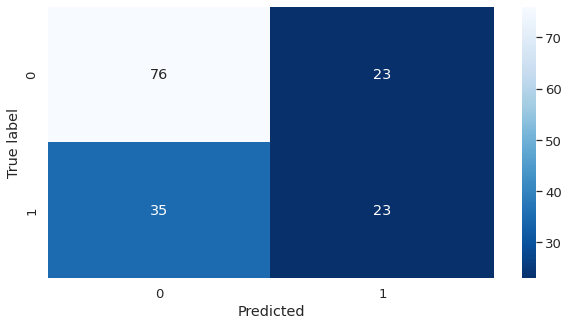

In [875]:
# создадим константу, чтобы выборка не менялась и улучшение модели было на одной базе.
RANDOM_STATE = 66


# выделим в отдельные переменные целевой признак и входные признаки
X = data_for_model3.drop(['milk_flavour'], axis=1)
y = data_for_model3['milk_flavour']

# делим данные на тестовую и основную выборку, а также фиксируем нашу константу
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = RANDOM_STATE)

# создадим список категориальных признаков тренировочной выборки.
cat_col_names = ['breed', 'pasture_type', 'daddys_breed', 'age', 'daddys_name', 'spr', 'fatness']

# создадим список количественных признаков тренировочной выборки.
num_col_names = ['efu', 'protein']

# создадим переменную для маштабирования методом стандартизации
scaler = StandardScaler()

# обучим и трансформируем количественные признаки из тренировочной выборки 
X_train_scaled = scaler.fit_transform(X_train[num_col_names])

# выполним преобразование для тестовой выборки
X_test_scaled = scaler.transform(X_test[num_col_names])

# Теперь перейдем к категориальным столбцам
# создадим переменную с экземпляром класса OneHotEncoder(), а также удалим один столбец во избежинии дамми-ловушки
encoder = OneHotEncoder(drop='first', sparse=False)

# обучим и трансформируйте категориальные признаки из тренировочной выборки 
X_train_ohe = encoder.fit_transform(X_train[cat_col_names]) 

# выполним преобразование для тестовой выборки
X_test_ohe = encoder.transform(X_test[cat_col_names]) 

# получим список новых столбцов
encoder_col_names = encoder.get_feature_names()

# создаём тренировочный и тестовый датафреймы из закодированных и отмасштабированных данных
X_train_ohe = pd.DataFrame(X_train_ohe, columns=encoder_col_names)
X_test_ohe = pd.DataFrame(X_test_ohe, columns=encoder_col_names)

X_train_scaled = pd.DataFrame(X_train_scaled, columns=num_col_names)
X_test_scaled = pd.DataFrame(X_test_scaled, columns=num_col_names)

# объединяем все преобразованные данные в тренировочный и тестовый датафреймы
X_train = pd.concat([X_train_ohe, X_train_scaled], axis=1)
X_test = pd.concat([X_test_ohe, X_test_scaled], axis=1)

# запускаем модель логистической регрессии
clf = LogisticRegression()

# обучаем модель на тренировочных данных
clf = clf.fit(X_train, y_train)

# получаем предсказания модели на тестовых данных
predictions = clf.predict(X_test)

plt.figure(figsize=(10,5))
cm = confusion_matrix(y_test, predictions)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues_r')
plt.ylabel('True label')
plt.xlabel('Predicted'); 


recall = recall_score(y_test, predictions)
precision = precision_score(y_test, predictions)

print('recall: ',round(recall ,3))
print('precision: ',round(precision,3))

Для нашей модели мы получили показатели 0.5 для ошибки 1-го рода (precision) и 0.40 для ошибки 2-го рода (recall). Наша задача состоит в том, чтобы минимизировать ошибку 1-го рода, т.е. чтобы модель определяла вкусное молоко и не важно если она случайно не зачтет вкусное молоко, как вкусное. Значит нужно улучшать показатель **precision**.

recall:  0.034
precision:  1.0


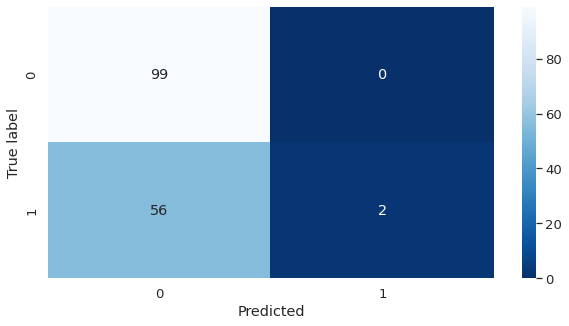

In [876]:
y_proba = clf.predict_proba(X_test)[:,1]
data_lin_reg = pd.DataFrame(zip(y_test, y_proba),
             columns = ['y_valid', 'y_proba']).sort_values(by='y_proba',ascending=False)
y_proba = data_lin_reg['y_proba'].apply(lambda x: 0 if x > 0.13 else 1)

plt.figure(figsize=(10,5))
cm = confusion_matrix(y_test, y_proba)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues_r')
plt.ylabel('True label')
plt.xlabel('Predicted'); 


recall = recall_score(y_test, y_proba)
precision = precision_score(y_test, y_proba)

print('recall: ',round(recall ,3))
print('precision: ',round(precision,3))

Мы настроили модель, чтобы она не учитывала ошибку первого вида и теперь ее precision равен 1. Так как мы добились снижения нуля ошибок при значении в 0.13 давайте выведем разные значения, чтобы помочь фермеру подобрать оптимальный порог.

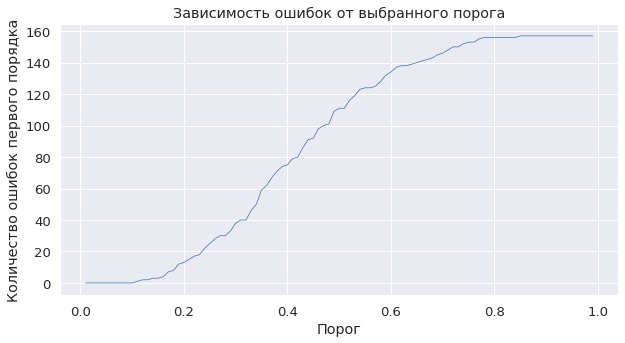

In [877]:
thresholds = [round(i,2) for i in np.linspace(0.01,1,num = 100,endpoint=False)]

values = []
columns = []
for i in thresholds:
    columns.append('y_pred_'+str(i))
    data_lin_reg['y_pred_'] = data_lin_reg['y_proba'].apply(lambda x: 1 if x<= i else 0)
    values.append(data_lin_reg['y_pred_'].sum())

plt.figure(figsize=(10,5))
heatmap = sns.lineplot(x=thresholds, y=[i for i in values], size = 50, 
                    legend=False)
plt.ylabel('Количество ошибок первого порядка')
plt.xlabel('Порог')
plt.title('Зависимость ошибок от выбранного порога'); 

<div class="alert alert-success">
<h2>V2 Комментарий ревьюера <a class="tocSkip"> </h2>

<b>Все отлично!👍</b> 
    

Теперь давайте добавим данные в датасет с предпологаеммыми покупками бурёнок.

Произведем все конвертации для основной выборки

In [878]:
data_prediction2 = data_buy
data_prediction2['efu'] = data_prediction2['efu'] ** 2
data_prediction2['spr'] = data_prediction2['spr'].apply(lambda x: 1 if x>= 0.92 else 0)
data_prediction2['fatness'] = data_prediction2['fatness'].apply(lambda x: 1 if x>= 3.68 else 0)

In [879]:
# создадим константу, чтобы выборка не менялась и улучшение модели было на одной базе.
RANDOM_STATE = 66


# выделим в отдельные переменные целевой признак и входные признаки
X = data_for_model3.drop(['milk_flavour'], axis=1)
y = data_for_model3['milk_flavour']

# делим данные на тестовую и основную выборку, а также фиксируем нашу константу
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = RANDOM_STATE)

# создадим список категориальных признаков тренировочной выборки.
cat_col_names = ['breed', 'pasture_type', 'daddys_breed', 'age', 'daddys_name', 'spr', 'fatness']

# создадим список количественных признаков тренировочной выборки.
num_col_names = ['efu', 'protein']

# создадим переменную для маштабирования методом стандартизации
scaler = StandardScaler()

# обучим и трансформируем количественные признаки из тренировочной выборки 
X_train_scaled = scaler.fit_transform(X_train[num_col_names])

# выполним преобразование для тестовой выборки
X_test_scaled = scaler.transform(X_test[num_col_names])

# выполним преобразование данных для предсказании
data_prediction2_scaled = scaler.transform(data_prediction2[num_col_names])

# Теперь перейдем к категориальным столбцам
# создадим переменную с экземпляром класса OneHotEncoder(), а также удалим один столбец во избежинии дамми-ловушки
encoder = OneHotEncoder(drop='first', sparse=False)

# обучим и трансформируйте категориальные признаки из тренировочной выборки 
X_train_ohe = encoder.fit_transform(X_train[cat_col_names]) 

# выполним преобразование для тестовой выборки
X_test_ohe = encoder.transform(X_test[cat_col_names]) 

# выполним преобразование данных для предсказании
data_prediction2_ohe = encoder.transform(data_prediction2[cat_col_names]) 

# получим список новых столбцов
encoder_col_names = encoder.get_feature_names()

# создаём тренировочный и тестовый датафреймы из закодированных и отмасштабированных данных
X_train_ohe = pd.DataFrame(X_train_ohe, columns=encoder_col_names)
X_test_ohe = pd.DataFrame(X_test_ohe, columns=encoder_col_names)
data_prediction2_ohe = pd.DataFrame(data_prediction2_ohe, columns=encoder_col_names)

X_train_scaled = pd.DataFrame(X_train_scaled, columns=num_col_names)
X_test_scaled = pd.DataFrame(X_test_scaled, columns=num_col_names)
data_prediction2_scaled = pd.DataFrame(data_prediction2_scaled, columns=num_col_names)

# объединяем все преобразованные данные в тренировочный и тестовый датафреймы
X_train = pd.concat([X_train_ohe, X_train_scaled], axis=1)
X_test = pd.concat([X_test_ohe, X_test_scaled], axis=1)
data_prediction2 = pd.concat([data_prediction2_ohe, data_prediction2_scaled], axis=1)

# запускаем модель логистической регрессии
clf = LogisticRegression()

# обучаем модель на тренировочных данных
clf = clf.fit(X_train, y_train)

# получаем предсказания модели на тестовых данных
predictions = clf.predict(data_prediction2)


# вносим изменения
y_proba = clf.predict_proba(X_test)[:,1]
data_lin_reg = pd.DataFrame(zip(y_test, y_proba),
              columns = ['y_valid', 'y_proba']).sort_values(by='y_proba',ascending=False)
y_proba = data_lin_reg['y_proba'].apply(lambda x: 0 if x > 0.13 else 1)

# добавляем данные
data_buy.insert(column = 'predict_milk_flavour', value = y_proba, loc = 12)

In [880]:
data_buy = data_buy.drop(columns = {'milk_yield', 'efu', 'raw_protein', 'spr', 'fatness'}, axis=1)
data_buy

,breed,pasture_type,daddys_breed,daddys_name,protein,age,predict_milk_yield,predict_milk_flavour
0,Вис Бик Айдиал,Холмистое,Айдиал,Геркулес,3.076,более_2_лет,6579.151156,0
1,Вис Бик Айдиал,Равнинное,Соверин,Буйный,3.081,менее_2_лет,6297.825182,0
2,РефлешнСоверинг,Равнинное,Соверин,Барин,3.074,более_2_лет,6264.818218,0
3,РефлешнСоверинг,Холмистое,Айдиал,Буйный,3.061,более_2_лет,6592.205542,0
4,РефлешнСоверинг,Равнинное,Айдиал,Буйный,3.074,более_2_лет,6525.020021,0
5,РефлешнСоверинг,Равнинное,Соверин,Геркулес,3.053,менее_2_лет,6340.186107,0
6,Вис Бик Айдиал,Холмистое,Айдиал,Геркулес,3.076,более_2_лет,6579.151156,0
7,Вис Бик Айдиал,Равнинное,Соверин,Буйный,3.079,более_2_лет,6504.592845,0
8,РефлешнСоверинг,Равнинное,Соверин,Барин,3.074,более_2_лет,6264.818218,0
9,РефлешнСоверинг,Холмистое,Айдиал,Буйный,3.079,менее_2_лет,6385.437879,0


Мы добавили данные в список с покупкой бурёнок

## Итоговые выводы

***Сноска только для ревьюера***
Я очень надеюсь, что тут нет столько ошибок или поправок, что тебе захочится "выколоть глаза". Если честно мне не хватило материала в курсе, чтобы быть полностью увереным в данном проекте, поэтому буду благодарен за напутсвие и советы. Я бы мог дальше делать исправления, но уже вымотан поиском информации в интернете, а также давит дедлайн. Надеюсь мой проект в таком виде не сильно тебя огорчит.

Мы проанализировали данные из датафреймов, а также список для покупки. Какие можно дать реккомендации:
- Проверить обновленный список с данными
- Хоть модель дает прогноз для каждой бурёнки на 6000 кг удоя в год, все таки мы добавили 5% для каждого показателя, а также существуют отклонения ошибок. Для нашей модели есть оклонение в -400 кг, а значит для точной уверености покупать бурёнок с показателем 6400+ кг удоя в год
- Не брать бурёнок младше 2 лет, и обращать внимание на жирность молока, так как показатели выше 3,7% с большей вероятностью дадут больше молока
- Из исследовательского анализа рекоммендую брать породу Айдиал и тех кто жил на холмистой территории, так как у других есть условный порог в 7000 кг в год
- К сожалению наша модель не дала для данного списка бурёнок с вкусным молоком. Так вышло поскольку мы полностью исключили ошибку первого рода. Реккомендую пересмотреть данный подход, чтобы была вероятность этого. Тогда мы сможем подобрать варианты из списка.
- Чтобы улучшить модель, можно подобрать больше параметров, а также по возможность добавить данные по характиристике корма для списка к покупке, чтобы еще сильнее улучшить нашу модель.

С точки зрения бизнеса данная модель может давать полезные рекоммендации по удою и вкусу молока. Для улучшения линейной регрессии можно подумать о добавлений новых показателей, но главное исключать мультиколлегиарность между признаками, а также исключать признаки не имеющих корреляции с целевым признаком. Для логистической регрессии можно пересмотреть порог данных с ошибкой первого типа, а также добавить больше данных о покупаемых бурёнках. На основании имеющихся данных мы в нашей модели учитывали бинарность признаков, а также квадратическую зависимость, что позволило улучшить модель. Больше данных или дальнейшее наблюдение позволит нам дальше улучшать признаки или их менять, в случае кардинальных изменений в данных по каким-либо причинам. Также не стоит смотреть только на финальные показатели, а важно пользоваться метриками моделей, такие как MSE, r2 и MAE для линейной регресии и данные по recall и precision для логистической модели для достижения найлучших результатов.

<div class="alert alert-warning">
    <h2> Комментарий ревьюера <a class="tocSkip"> </h2>
    
<b>Некоторые замечания и рекомендации💡:</b> 
        
В финальном выводе стоит написать больше мыслей и идей по бизнесовой части и по моделям        


<div class="alert alert-info" style="border-radius: 15px; box-shadow: 4px 4px 4px; border: 1px solid " ><b> Комментарий студента : </b>

Спасибо большое за теплые слова и комментарии. Добавил в финальный вывод доп выводы по модели. Надеюсь теперь мой проект стал лучше и изменения оказалсь полезны.
    
Если ты примишь мой проект со второй отправки, то заранее спасибо за потраченное время и ценные советы. Если нужны будут доработки, то еще спишимся :)
</div>

<div class="alert alert-info">
    <h2> Комментарий ревьюера <a class="tocSkip"> </h2>

    
**Общий вывод по проекту**

Спасибо за твой проект! В него действительно вложено много сил и времени! Есть несколько важных моментов, которые я отметил и которые можно было бы улучшить, подсказки ты найдешь в моих комментариях. 

**Отмечу отдельные положительные моменты проекта🙂**:
 
* Использование методов из программы курса на высоте. Хорошая работа!
* Работа проделана действительно масштабная и видно, что ты очень стараешься!
* Отлично разработаны функции!



**Хорошая работа, ошибок не очень много, а графики так вообще отличные! Скорректируй те моменты, на которые я указал и отправляй проект на повторное ревью!**😉


<div class="alert alert-info">
<h2>V2 Общий вывод <a class="tocSkip"> </h2>
    
Теперь всё отлично, спасибо за работу! Было приятно её проверять🙂

Если честно, ты молодец всё сделано очень грамотно, это довольно сложная и объёмная работа. 
    
Если есть желание поподробнее познакомиться с этой темой, вот список литературы с которой можно ознакомиться:
    
* https://education.yandex.ru/handbook/ml/article/linear-models
    
* https://habr.com/ru/companies/ods/articles/323890/
    
* https://habr.com/ru/articles/278513/
    
    
**Успехов в дальнейшей учёбе!**